# Basin-level Descriptive Analysis
This notebook performs exploratory data analysis for WWLLN inner core and rainband lightning with a focus on basins using the filtered dataset. We exclude CPAC from the basin-specific sections due to data sparsity.
This notebook should be executed after the `data_pipeline/` notebooks.

This notebook includes the following sections:
- Inner Core Basin Comparison
- Rainband Basin Comparison
- Shear Quadrant Rainband Basin Comparison

## Requirements
This notebook requires the following libraries not built-in to Python:
- matplotlib
- numpy
- pandas
- polars


This notebook requires the following files in [data_pipeline/](../data_pipeline/)
- `data/innercore_timebin_joined.csv`
- `intermediate_data/Filtered_Reduced_Trackfile.csv`

## Code
Start by importing necessary libraries.

In [55]:
import pandas as pd
import numpy as np
import polars as pl
import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option('display.max_rows', 500)

### Inner Core Basin Comparison
Read in the inner core dataset. Note that this dataset is already filtered to TCs category 1 or higher.

In [35]:
# Import inner core data from csv file
innercore_data = pl.read_csv("../data_pipeline/data/innercore_timebin_joined.csv")
innercore_data = innercore_data.with_columns(
    pl.col("time_bin").str.strptime(pl.Datetime).alias("time_bin"),
    pl.col("storm_code").str.extract(r"^(.*?)_", 1).alias("basin"),
    pl.col("lightning_count").log1p().alias("log_lightning_count"),
    pl.when(pl.col("pressure") == 0)
    .then(None)  # Replace 0 with None -> 0 is not possible, treat these as null but don't remove row bc the wind speed value is valid
    .otherwise(pl.col("pressure"))
    .alias("pressure")  # Keep the column name as "pressure"
)
innercore_data = innercore_data.with_columns(
    pl.when(pl.col("Current_Category") == "Unidentified")
    .then(pl.lit("0")) # Replace "unidentified" with 0 for current category
    .otherwise(pl.col("Current_Category"))
    .alias("Current_Category")
)
innercore_data.head()

time_bin,storm_code,lightning_count,year,month,day,hour,minute,lat,lon,pressure,knots,storm_name,category,basin,minute_right,24_hour_knots_diff,24_hour_pressure_diff,Current_Category,Intensification_Category,log_lightning_count
datetime[μs],str,i64,i64,i64,i64,i64,i64,f64,f64,i64,i64,str,i64,str,i64,f64,f64,str,str,f64
2010-06-21 07:00:00,"""ATL_10_1""",1,2010,6,21,7,0,13.4,-66.5,1011,20,"""Alex""",2,"""ATL""",0,5.0,-1.0,"""0""","""Neutral""",0.693147
2010-06-21 07:30:00,"""ATL_10_1""",0,2010,6,21,7,30,13.4,-66.5,1011,20,"""Alex""",2,"""ATL""",0,5.0,-1.0,"""0""","""Neutral""",0.0
2010-06-21 08:00:00,"""ATL_10_1""",0,2010,6,21,8,0,13.4,-66.5,1011,20,"""Alex""",2,"""ATL""",0,5.0,-1.0,"""0""","""Neutral""",0.0
2010-06-21 08:30:00,"""ATL_10_1""",0,2010,6,21,8,30,13.4,-66.5,1011,20,"""Alex""",2,"""ATL""",0,5.0,-1.0,"""0""","""Neutral""",0.0
2010-06-21 09:00:00,"""ATL_10_1""",0,2010,6,21,9,0,14.0,-67.6,1011,20,"""Alex""",2,"""ATL""",0,5.0,-1.0,"""0""","""Neutral""",0.0


In [3]:
# Import filtered track file
track_data = pd.read_csv("../data_pipeline/intermediate_data/Filtered_Reduced_Trackfile.csv")

track_data.head()

,year,month,day,hour,lat,lon,pressure,knots,storm_code,storm_name,category,basin
0,2020,10,20,0,12.1,-80.0,0,15,ATL_20_28,Zeta,2,ATL
1,2020,10,20,6,12.5,-80.1,0,15,ATL_20_28,Zeta,2,ATL
2,2020,10,20,12,12.8,-80.2,0,15,ATL_20_28,Zeta,2,ATL
3,2020,10,20,18,13.2,-80.3,0,15,ATL_20_28,Zeta,2,ATL
4,2020,10,21,0,13.8,-80.4,0,15,ATL_20_28,Zeta,2,ATL


Let's start by looking at the number of storms per basin in the filtered inner core lightning dataset.

In [4]:
# Number of storms per basin
innercore_basin_count = innercore_data.group_by("basin").agg(pl.struct("storm_code").n_unique().alias("unique_tc_count"))
innercore_basin_count = innercore_basin_count.to_pandas()
innercore_basin_count

,basin,unique_tc_count
0,IO,26
1,SHEM,127
2,CPAC,7
3,EPAC,82
4,ATL,84
5,WPAC,146


Next, let's look at the storm durations over the different basins.

In [5]:
# Create a 'datetime' column by combining year, month, day, hour into a datetime string
track_data['datetime'] = pd.to_datetime(track_data[['year', 'month', 'day', 'hour']])

# Sort by storm_code and datetime
df = track_data.sort_values(by=['storm_code', 'datetime'])

# Calculate the storm duration for each storm
# Group by storm_code and calculate the difference between the first and last datetime
storm_duration = df.groupby(['storm_code', 'basin']).agg(
    storm_start=('datetime', 'min'),
    storm_end=('datetime', 'max')
)

# Calculate the duration in timedelta
storm_duration['duration'] = storm_duration['storm_end'] - storm_duration['storm_start']

# Display the results
storm_duration.head()

,,storm_start,storm_end,duration
storm_code,basin,,,
ATL_10_1,ATL,2010-06-20 18:00:00,2010-07-01 18:00:00,11 days 00:00:00
ATL_10_11,ATL,2010-09-07 00:00:00,2010-09-21 18:00:00,14 days 18:00:00
ATL_10_12,ATL,2010-09-12 06:00:00,2010-09-24 12:00:00,12 days 06:00:00
ATL_10_13,ATL,2010-09-09 12:00:00,2010-09-18 00:00:00,8 days 12:00:00
ATL_10_14,ATL,2010-09-20 00:00:00,2010-09-28 18:00:00,8 days 18:00:00


In [6]:
# Grab the duration column
time_deltas = storm_duration['duration']

# Convert timedelta to days
storm_duration['duration_days'] = time_deltas / pd.Timedelta(days=1)  # Converts to float days
storm_duration.head()

,,storm_start,storm_end,duration,duration_days
storm_code,basin,,,,
ATL_10_1,ATL,2010-06-20 18:00:00,2010-07-01 18:00:00,11 days 00:00:00,11.00
ATL_10_11,ATL,2010-09-07 00:00:00,2010-09-21 18:00:00,14 days 18:00:00,14.75
ATL_10_12,ATL,2010-09-12 06:00:00,2010-09-24 12:00:00,12 days 06:00:00,12.25
ATL_10_13,ATL,2010-09-09 12:00:00,2010-09-18 00:00:00,8 days 12:00:00,8.50
ATL_10_14,ATL,2010-09-20 00:00:00,2010-09-28 18:00:00,8 days 18:00:00,8.75


In [45]:
# Get unique storm codes with basin
innercore_storms = innercore_data[["storm_code", "basin"]].unique()
innercore_storms_pd = innercore_storms.to_pandas()

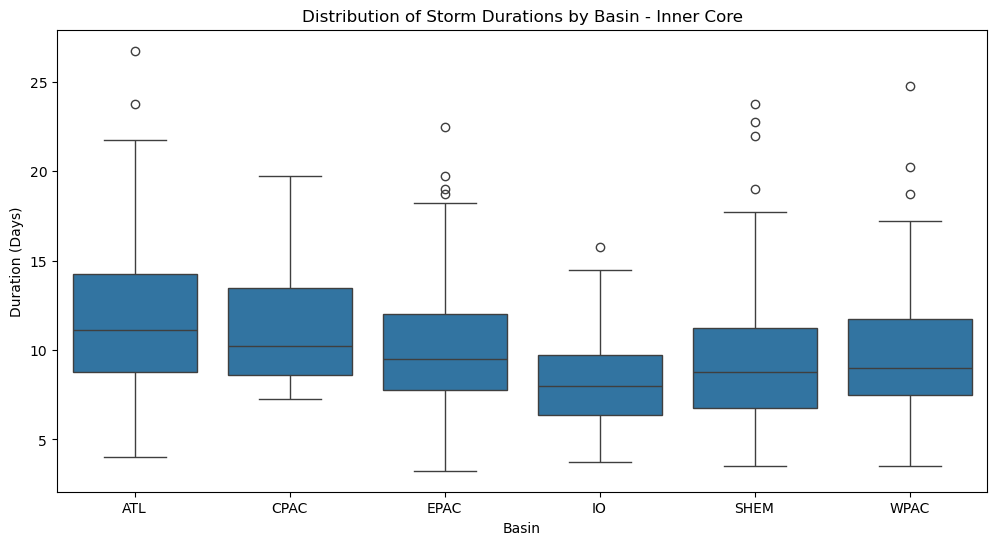

In [50]:
# Plot boxplots for each basin, filter to TCs with data in inner core
storm_duration_inner = storm_duration.merge(innercore_storms_pd, how="inner", on=["storm_code", "basin"])
plt.figure(figsize=(12, 6))
sns.boxplot(data=storm_duration, x='basin', y='duration_days')

# Labels and title
plt.xlabel('Basin')
plt.ylabel('Duration (Days)')
plt.title('Distribution of Storm Durations by Basin - Inner Core')

# Show plot
plt.show()

Next, we look at the number of lightning events associated with each overall TC category of storm in each basin, which we define using the max wind speed of the TC and the [Saffir-Simpson Hurricane Wind Scale](../README.md#background-information).

In [8]:
# Convert to pandas dataframe
innercore_data = innercore_data.to_pandas()
# Group by basin and get the lightning count per category
innercore_data.groupby(['basin'])['category'].value_counts().sort_index(level=['basin','category'])

basin  category
ATL    1           15426
       2            8294
       3            4832
       4           10238
       5            2354
CPAC   1            1526
       2            1629
       5             402
EPAC   1            9074
       2            3875
       3            3437
       4           14826
       5            1918
IO     1            3500
       2             434
       3            1714
       4            2131
       5             266
SHEM   1           12061
       2            8021
       3            6555
       4           14736
       5            5155
WPAC   1           11006
       2            5616
       3            6228
       4           15985
       5           15881
Name: count, dtype: int64

Let's also look at the number of lightning events associated with each current category for each basin. Note that unlike the overall TC category, this category is defined by the wind speed at the time of the lightning.

In [9]:
# Get lightning counts per current category
innercore_data.groupby('basin')['Current_Category'].value_counts()

basin  Current_Category
ATL    0                   29251
       1                    6162
       2                    2483
       3                    1606
       4                    1366
       5                     276
CPAC   0                    2737
       1                     510
       2                     154
       4                     102
       3                      36
       5                      18
EPAC   0                   22597
       1                    4433
       2                    2166
       3                    2101
       4                    1721
       5                     112
IO     0                    5537
       1                    1236
       2                     426
       4                     416
       3                     406
       5                      24
SHEM   0                   31142
       1                    6503
       2                    3728
       3                    2638
       4                    2217
       5           

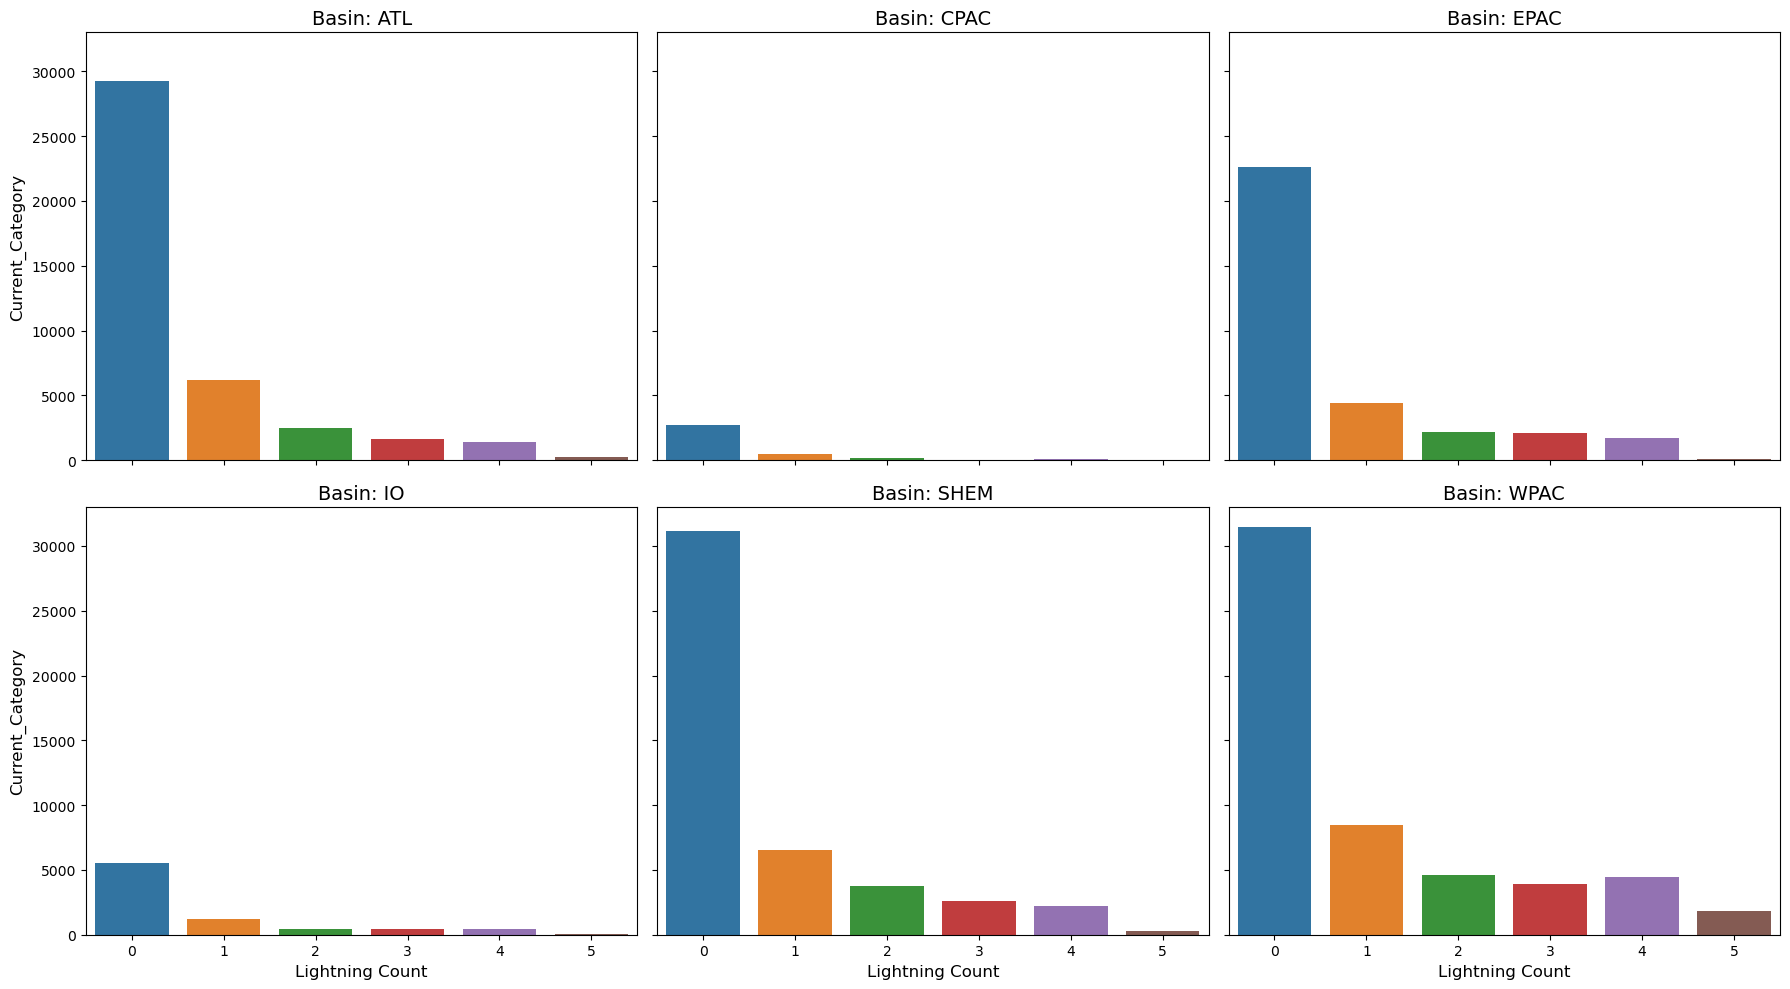

In [71]:
# Visualize by basin
# Filter out 'Unidentified' from Current_Category
filtered_data = innercore_data[innercore_data['Current_Category'] != 'Unidentified']

category_counts = filtered_data.groupby(['basin', 'Current_Category']).size().reset_index(name='count')

# Get unique basins
basins = category_counts['basin'].unique()

# Define a color palette for consistency across plots
unique_categories = category_counts['Current_Category'].unique()
palette = sns.color_palette("tab10", len(unique_categories))
category_colors = {category: palette[i] for i, category in enumerate(unique_categories)}

# Create a 2x3 grid of subplots
fig, axes = plt.subplots(2, 3, figsize=(18, 10), sharex=True, sharey=True)

# Flatten axes array for easier indexing
axes = axes.flatten()

# Loop through each basin and plot a bar chart
for i, basin in enumerate(basins):
    ax = axes[i]

    # Filter data for the current basin
    basin_data = category_counts[category_counts['basin'] == basin]

    # Plot bar chart
    sns.barplot(
        data=basin_data,
        y='count',
        x='Current_Category',
        ax=ax,
        hue='Current_Category',  # Assign hue
        palette=category_colors,
        legend=False  # Prevent duplicate legends in subplots
    )

    ax.set_title(f'Basin: {basin}', size=14)
    ax.set_xlabel('Lightning Count', size=12)
    ax.set_ylabel('Current_Category', size=12)

# Remove empty subplots if basins < 6
for j in range(len(basins), 6):
    fig.delaxes(axes[j])

# Adjust layout
plt.tight_layout()
plt.show()

Let's look at the number of lightning events for each intensification category over the different basins.

In [11]:
# Get counts per basin for the intensification categories
innercore_data.groupby('basin')['Intensification_Category'].value_counts()

basin  Intensification_Category
ATL    Neutral                     19954
       Intensifying                10855
       Unidentified                 4032
       Weakening                    3376
       Rapidly Intensifying         2323
       Rapidly Weakening             604
CPAC   Neutral                      1569
       Intensifying                 1057
       Weakening                     363
       Unidentified                  336
       Rapidly Intensifying          120
       Rapidly Weakening             112
EPAC   Neutral                     12737
       Intensifying                 9033
       Unidentified                 3936
       Weakening                    3665
       Rapidly Intensifying         2911
       Rapidly Weakening             848
IO     Neutral                      2709
       Intensifying                 2290
       Unidentified                 1217
       Rapidly Intensifying          739
       Weakening                     648
       Rapidly Weakening 

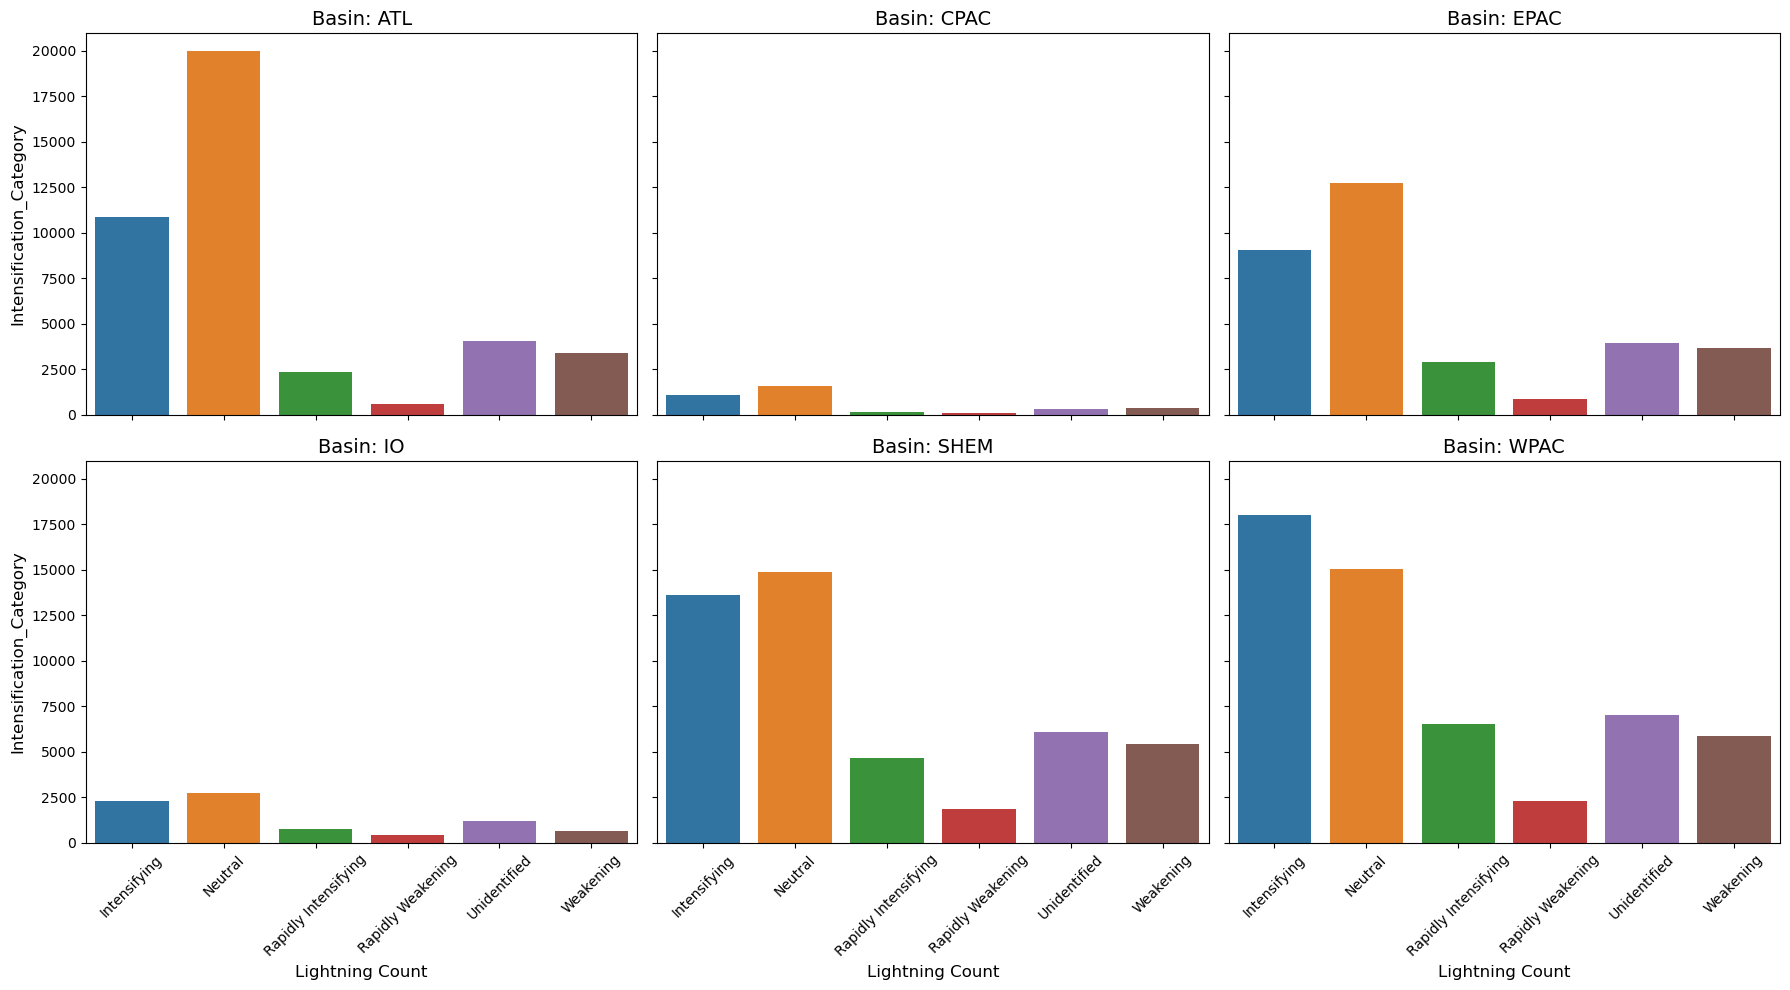

In [72]:
# Visualize by basin
# Group data and count occurrences of each intensification category per basin
category_counts = innercore_data.groupby(['basin', 'Intensification_Category']).size().reset_index(name='count')

# Get unique basins
basins = category_counts['basin'].unique()

# Define a color palette for consistency across plots
unique_categories = category_counts['Intensification_Category'].unique()
palette = sns.color_palette("tab10", len(unique_categories))
category_colors = {category: palette[i] for i, category in enumerate(unique_categories)}

# Create a 2x3 grid of subplots
fig, axes = plt.subplots(2, 3, figsize=(18, 10), sharex=True, sharey=True)

# Flatten axes array for easier indexing
axes = axes.flatten()

# Loop through each basin and plot a bar chart
for i, basin in enumerate(basins):
    ax = axes[i]

    # Filter data for the current basin
    basin_data = category_counts[category_counts['basin'] == basin]

    # Plot bar chart
    sns.barplot(
        data=basin_data,
        y='count',
        x='Intensification_Category',
        ax=ax,
        hue='Intensification_Category',  # Assign hue
        palette=category_colors,
        legend=False  # Prevent duplicate legends in subplots
    )

    ax.set_title(f'Basin: {basin}', size=14)
    ax.set_xlabel('Lightning Count', size=12)
    ax.set_ylabel('Intensification_Category', size=12)
    # Rotate x-axis labels
    for label in ax.get_xticklabels():
        label.set_rotation(45)

# Remove empty subplots if basins < 6
for j in range(len(basins), 6):
    fig.delaxes(axes[j])

# Adjust layout
plt.tight_layout()
plt.show()

We also look at the maximum 24-hour difference in wind speeds per basin.

In [13]:
# Get max 24-hour wind speed difference per basin
innercore_data.groupby(['basin'])['24_hour_knots_diff'].max(['24_hour_knots_diff'])

basin
ATL      70.0
CPAC     70.0
EPAC    100.0
IO       80.0
SHEM    100.0
WPAC     85.0
Name: 24_hour_knots_diff, dtype: float64

We look at the distribution of lightning counts across basins, weighted by the number of storms per TC for better comparison.

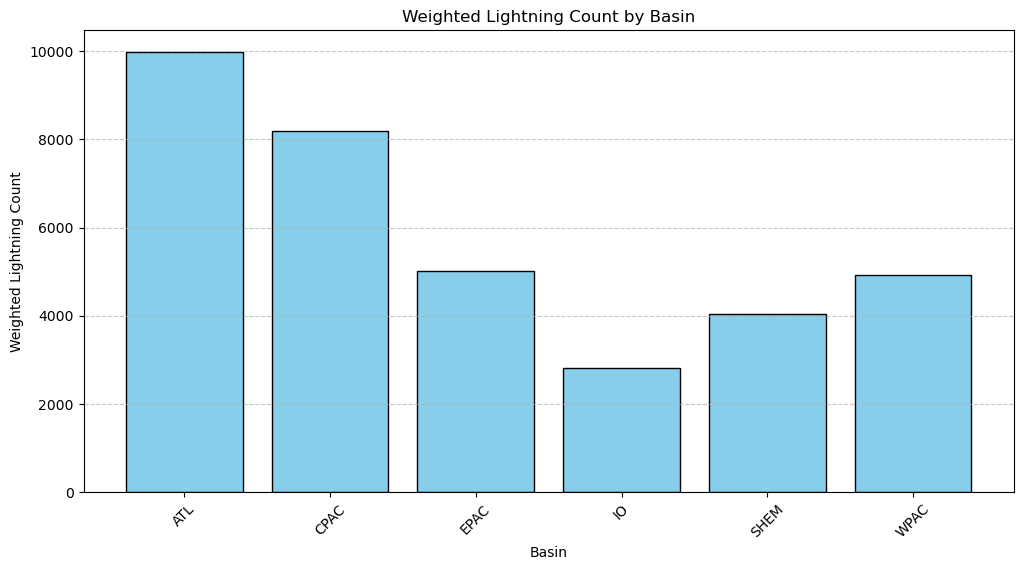

In [14]:
# Group by 'basin' and sum 'lightning count'
basin_lightning = innercore_data.groupby('basin')['lightning_count'].sum().reset_index()
# Merge to TC count per basin df
basin_lightning = basin_lightning.merge(innercore_basin_count, how="inner", on="basin")
# Calculate weighted lightning count
basin_lightning['weighted_count'] = basin_lightning['lightning_count']/basin_lightning['unique_tc_count']

# Plot
plt.figure(figsize=(12, 6))
plt.bar(basin_lightning['basin'], basin_lightning['weighted_count'], color='skyblue', edgecolor='black')

# Labels and title
plt.xlabel('Basin')
plt.ylabel('Weighted Lightning Count')
plt.title('Weighted Lightning Count by Basin')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Show plot
plt.show()

Let's take a look at the distribution of lightning counts across the different basins colored by intensification stage and current category. We log transform the lightning counts to get a better look.

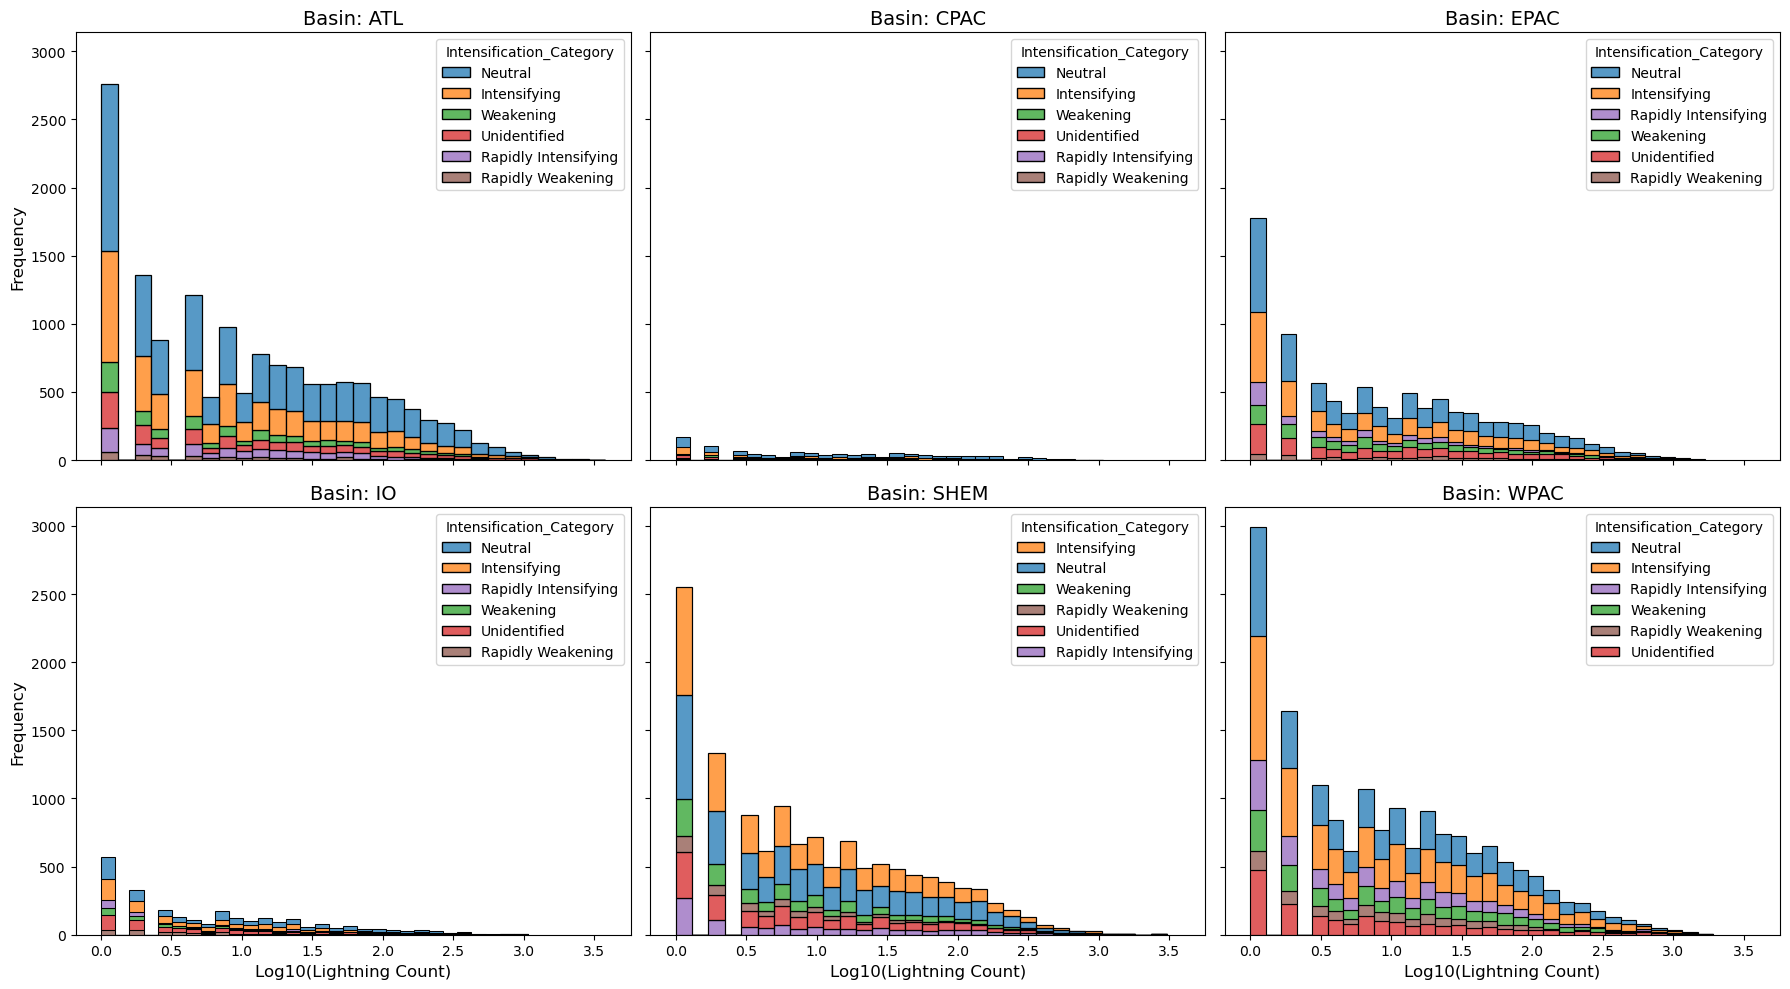

In [15]:
# Intensification stage
# Filter out zero lightning counts
filtered_data = innercore_data[innercore_data['lightning_count'] > 0].copy()

# Log-transform the lightning count
filtered_data['log_lightning_count'] = np.log10(filtered_data['lightning_count'])

# Get unique basins
basins = filtered_data['basin'].unique()

# Get unique categories and assign consistent colors
unique_categories = filtered_data['Intensification_Category'].unique()
palette = sns.color_palette("tab10", len(unique_categories))  # Using a fixed palette
category_colors = {category: palette[i] for i, category in enumerate(unique_categories)}

# Create a 2x3 grid of subplots
fig, axes = plt.subplots(2, 3, figsize=(18, 10), sharex=True, sharey=True)

# Flatten axes array for easier indexing
axes = axes.flatten()

# Loop through each basin and plot
for i, basin in enumerate(basins):
    ax = axes[i]

    # Filter data for the current basin
    basin_data = filtered_data[filtered_data['basin'] == basin]

    # Plot stacked histogram with consistent colors
    sns.histplot(
        data=basin_data,
        x='log_lightning_count',
        hue='Intensification_Category',
        multiple='stack',  # Stacked bars
        bins=30,
        ax=ax,
        palette=category_colors  # Apply consistent colors
    )

    ax.set_title(f'Basin: {basin}', size=14)
    ax.set_xlabel('Log10(Lightning Count)', size=12)
    ax.set_ylabel('Frequency', size=12)

# Remove empty subplots if basins < 6
for j in range(len(basins), 6):
    fig.delaxes(axes[j])

# Adjust layout
plt.tight_layout()
plt.show()

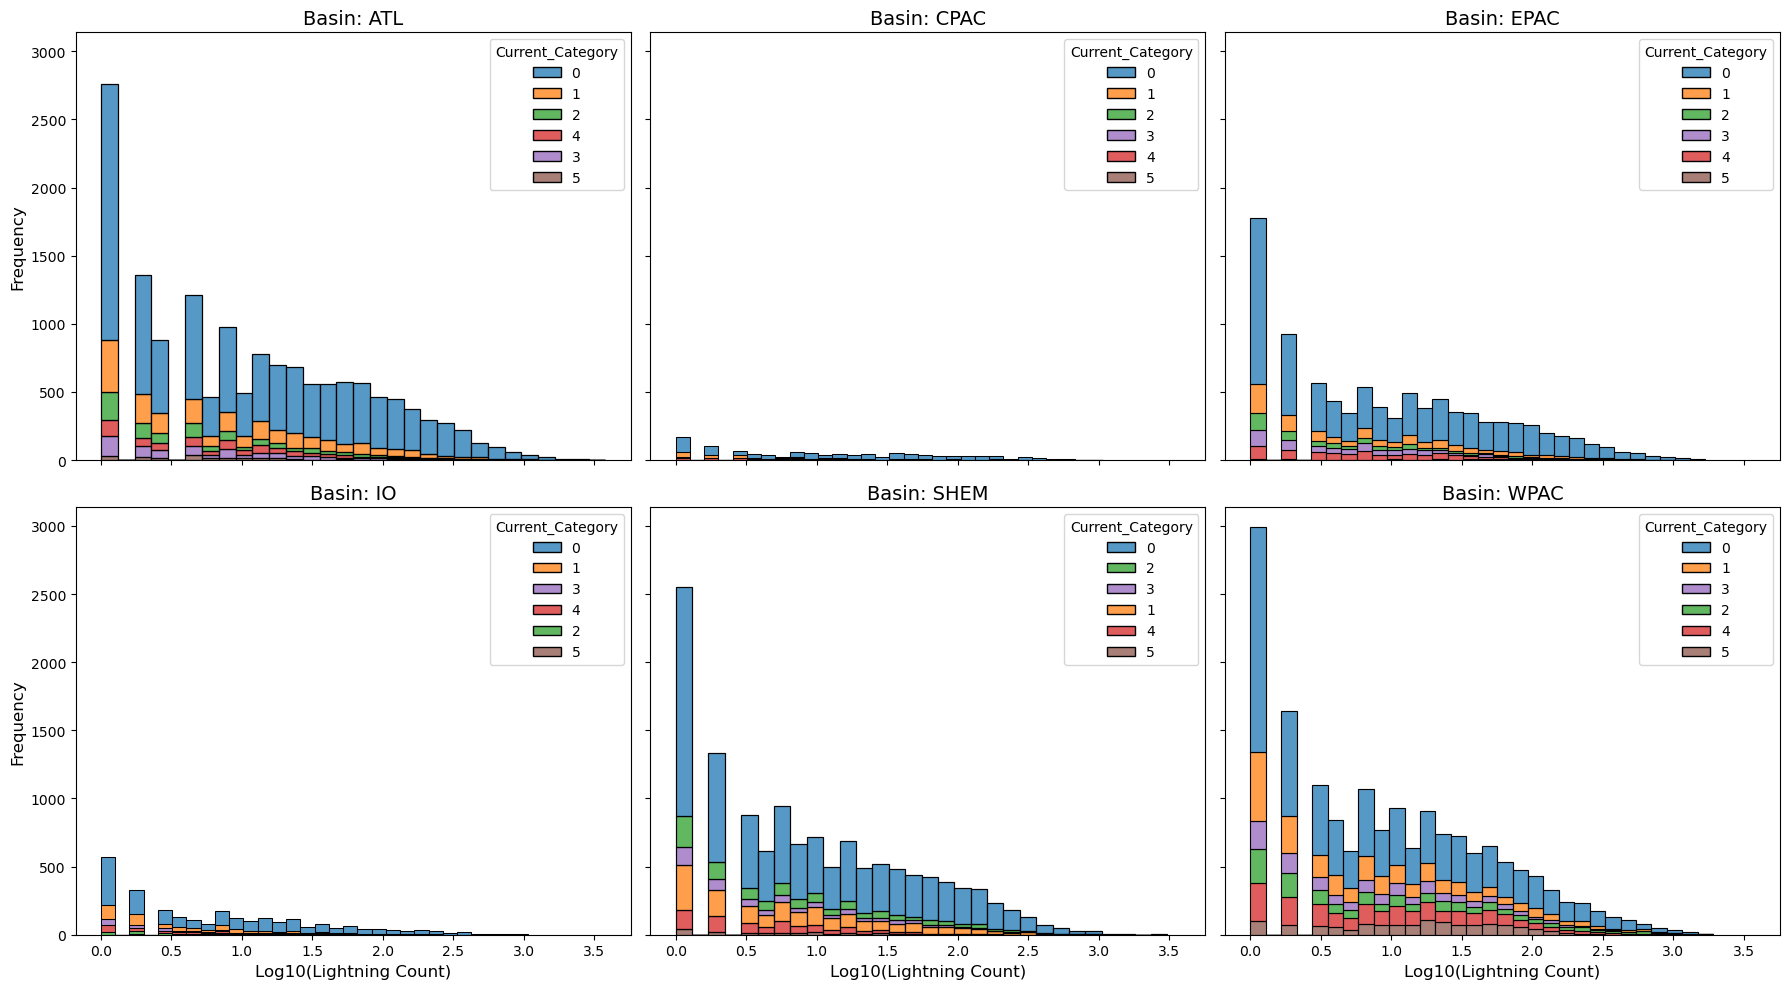

In [16]:
# Current Category
# Filter out zero lightning counts
filtered_data = innercore_data[innercore_data['lightning_count'] > 0].copy()

# Log-transform the lightning count
filtered_data['log_lightning_count'] = np.log10(filtered_data['lightning_count'])

# Get unique basins
basins = filtered_data['basin'].unique()

# Get unique categories and assign consistent colors
unique_categories = filtered_data['Current_Category'].unique()
palette = sns.color_palette("tab10", len(unique_categories))  # Using a fixed palette
category_colors = {category: palette[i] for i, category in enumerate(unique_categories)}

# Create a 2x3 grid of subplots
fig, axes = plt.subplots(2, 3, figsize=(18, 10), sharex=True, sharey=True)

# Flatten axes array for easier indexing
axes = axes.flatten()

# Loop through each basin and plot
for i, basin in enumerate(basins):
    ax = axes[i]

    # Filter data for the current basin
    basin_data = filtered_data[filtered_data['basin'] == basin]

    # Plot stacked histogram with consistent colors
    sns.histplot(
        data=basin_data,
        x='log_lightning_count',
        hue='Current_Category',
        multiple='stack',  # Stacked bars
        bins=30,
        ax=ax,
        palette=category_colors  # Apply consistent colors
    )

    ax.set_title(f'Basin: {basin}', size=14)
    ax.set_xlabel('Log10(Lightning Count)', size=12)
    ax.set_ylabel('Frequency', size=12)

# Remove empty subplots if basins < 6
for j in range(len(basins), 6):
    fig.delaxes(axes[j])

# Adjust layout
plt.tight_layout()
plt.show()

------------

### Rainband Basin Comparison
Read in the inner core dataset. Note that this dataset is already filtered to TCs category 1 or higher.

In [17]:
# Import data from csv file
rainband_data = pl.read_csv("../data_pipeline/data/rainband_shear_timebin_joined.csv")
rainband_data = rainband_data.with_columns(
    pl.col("time_bin").str.strptime(pl.Datetime).alias("time_bin"),
    pl.col("storm_code").str.extract(r"^(.*?)_", 1).alias("basin"),
    pl.col("lightning_count").log1p().alias("log_lightning_count"),
    pl.when(pl.col("pressure") == 0)
    .then(None)  # Replace 0 with None -> 0 is not possible, treat these as null but don't remove row bc the wind speed value is valid
    .otherwise(pl.col("pressure"))
    .alias("pressure")  # Keep the column name as "pressure"
)
rainband_data = rainband_data.with_columns(
    pl.when(pl.col("Current_Category") == "Unidentified")
    .then(pl.lit("0")) # Replace "unidentified" with 0 for current category
    .otherwise(pl.col("Current_Category"))
    .alias("Current_Category")
)
rainband_data.head()

time_bin,shear_quad,storm_code,lightning_count,year,month,day,hour,minute,lat,lon,pressure,knots,storm_name,category,basin,24_hour_knots_diff,24_hour_pressure_diff,Current_Category,Intensification_Category,log_lightning_count
datetime[μs],str,str,i64,i64,i64,i64,i64,i64,f64,f64,i64,i64,str,i64,str,f64,f64,str,str,f64
2010-06-20 18:00:00,"""DL""","""ATL_10_1""",0,2010,6,20,18,0,12.0,-64.3,1011,15,"""Alex""",2,"""ATL""",10.0,-1.0,"""0""","""Intensifying""",0.0
2010-06-20 18:00:00,"""DR""","""ATL_10_1""",0,2010,6,20,18,0,12.0,-64.3,1011,15,"""Alex""",2,"""ATL""",10.0,-1.0,"""0""","""Intensifying""",0.0
2010-06-20 18:00:00,"""UL""","""ATL_10_1""",0,2010,6,20,18,0,12.0,-64.3,1011,15,"""Alex""",2,"""ATL""",10.0,-1.0,"""0""","""Intensifying""",0.0
2010-06-20 18:00:00,"""UR""","""ATL_10_1""",0,2010,6,20,18,0,12.0,-64.3,1011,15,"""Alex""",2,"""ATL""",10.0,-1.0,"""0""","""Intensifying""",0.0
2010-06-20 18:30:00,"""DL""","""ATL_10_1""",0,2010,6,20,18,30,12.0,-64.3,1011,15,"""Alex""",2,"""ATL""",10.0,-1.0,"""0""","""Intensifying""",0.0


If not already loaded, import the filtered track file again.

In [18]:
# Import filtered track file
track_data = pd.read_csv("../data_pipeline/intermediate_data/Filtered_Reduced_Trackfile.csv")

track_data.head()

,year,month,day,hour,lat,lon,pressure,knots,storm_code,storm_name,category,basin,datetime
0,2020,10,20,0,12.1,-80.0,0,15,ATL_20_28,Zeta,2,ATL,2020-10-20 00:00:00
1,2020,10,20,6,12.5,-80.1,0,15,ATL_20_28,Zeta,2,ATL,2020-10-20 06:00:00
2,2020,10,20,12,12.8,-80.2,0,15,ATL_20_28,Zeta,2,ATL,2020-10-20 12:00:00
3,2020,10,20,18,13.2,-80.3,0,15,ATL_20_28,Zeta,2,ATL,2020-10-20 18:00:00
4,2020,10,21,0,13.8,-80.4,0,15,ATL_20_28,Zeta,2,ATL,2020-10-21 00:00:00


Let's start by looking at the number of storms per basin in the filtered rainband lightning dataset. We will have less TCs in the rainband analysis due to limitations on the shear dataset. Shear data is only available from 2010-2017 for a subset of the storms.

In [19]:
# Number of storms per basin
rainband_basin_count = rainband_data.group_by("basin").agg(pl.struct("storm_code").n_unique().alias("unique_tc_count"))
rainband_basin_count = rainband_basin_count.to_pandas()
rainband_basin_count

,basin,unique_tc_count
0,ATL,56
1,EPAC,59
2,WPAC,101
3,IO,12
4,SHEM,76


Note that this dataset does not have any storms in CPAC.

Next, let's look at the storm durations over the different basins.

In [47]:
# Get unique storm codes with basin
rainband_storms = rainband_data[["storm_code", "basin"]].unique()
rainband_storms_pd = rainband_storms.to_pandas()

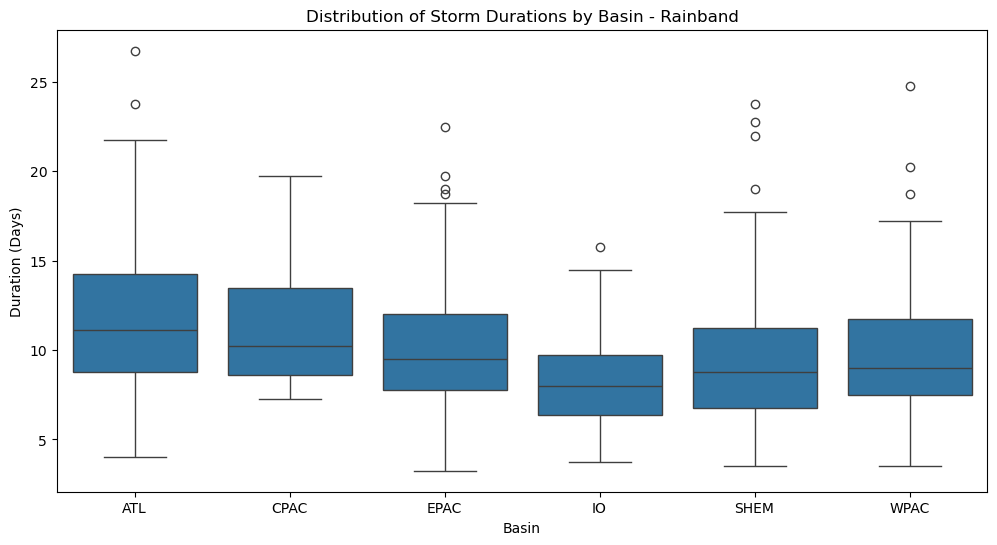

In [49]:
# Plot boxplots for each basin, filter to TCs with data in inner core
storm_duration_inner = storm_duration.merge(rainband_storms_pd, how="inner", on=["storm_code", "basin"])
plt.figure(figsize=(12, 6))
sns.boxplot(data=storm_duration, x='basin', y='duration_days')

# Labels and title
plt.xlabel('Basin')
plt.ylabel('Duration (Days)')
plt.title('Distribution of Storm Durations by Basin - Rainband')

# Show plot
plt.show()

Next, we look at the number of lightning events associated with each overall TC category of storm in each basin, which we define using the max wind speed of the TC and the [Saffir-Simpson Hurricane Wind Scale](../README.md#background-information).

In [52]:
# Convert to pandas dataframe
rainband_data = rainband_data.to_pandas()
# Group by basin and get the lightning count per category
rainband_data.groupby(['basin'])['category'].value_counts().sort_index(level=['basin','category'])

basin  category
ATL    1           52176
       2           21980
       3           18272
       4           30092
       5            6296
EPAC   1           37964
       2           15584
       3           15724
       4           41116
       5            3272
IO     1            9716
       3            2648
       4            7508
SHEM   1           28880
       2           29352
       3           14720
       4           45116
       5           19996
WPAC   1           32104
       2           14444
       3           18144
       4           65888
       5           53424
Name: count, dtype: int64

Let's also group by shear quadrant.

In [56]:
# Group by basin and shear quadrant and get the lightning count per category
rainband_data.groupby(['basin', 'shear_quad'])['category'].value_counts().sort_index(level=['basin','category'])

basin  shear_quad  category
ATL    DL          1           13044
       DR          1           13044
       UL          1           13044
       UR          1           13044
       DL          2            5495
       DR          2            5495
       UL          2            5495
       UR          2            5495
       DL          3            4568
       DR          3            4568
       UL          3            4568
       UR          3            4568
       DL          4            7523
       DR          4            7523
       UL          4            7523
       UR          4            7523
       DL          5            1574
       DR          5            1574
       UL          5            1574
       UR          5            1574
EPAC   DL          1            9491
       DR          1            9491
       UL          1            9491
       UR          1            9491
       DL          2            3896
       DR          2            3896
       UL 

Let's also look at the number of lightning events associated with each current category for each basin. Note that unlike the overall TC category, this category is defined by the wind speed at the time of the lightning.

In [53]:
# Get lightning counts per current category
rainband_data.groupby('basin')['Current_Category'].value_counts()

basin  Current_Category
ATL    0                    91768
       1                    21136
       2                     7232
       3                     4624
       4                     3192
       5                      864
EPAC   0                    80728
       1                    16224
       2                     7392
       3                     5116
       4                     3936
       5                      264
IO     0                    14504
       1                     2848
       3                      960
       4                      840
       2                      720
SHEM   0                    94324
       1                    19900
       2                    10544
       4                     6552
       3                     5688
       5                     1056
WPAC   0                   106304
       1                    30256
       2                    16476
       4                    13384
       3                    13120
       5                

Once again, let's also look at the counts by shear quadrant.

In [57]:
# Get lightning counts per current category, shear quad
rainband_data.groupby(['basin', 'shear_quad'])['Current_Category'].value_counts()

basin  shear_quad  Current_Category
ATL    DL          0                   22942
                   1                    5284
                   2                    1808
                   3                    1156
                   4                     798
                   5                     216
       DR          0                   22942
                   1                    5284
                   2                    1808
                   3                    1156
                   4                     798
                   5                     216
       UL          0                   22942
                   1                    5284
                   2                    1808
                   3                    1156
                   4                     798
                   5                     216
       UR          0                   22942
                   1                    5284
                   2                    1808
                   

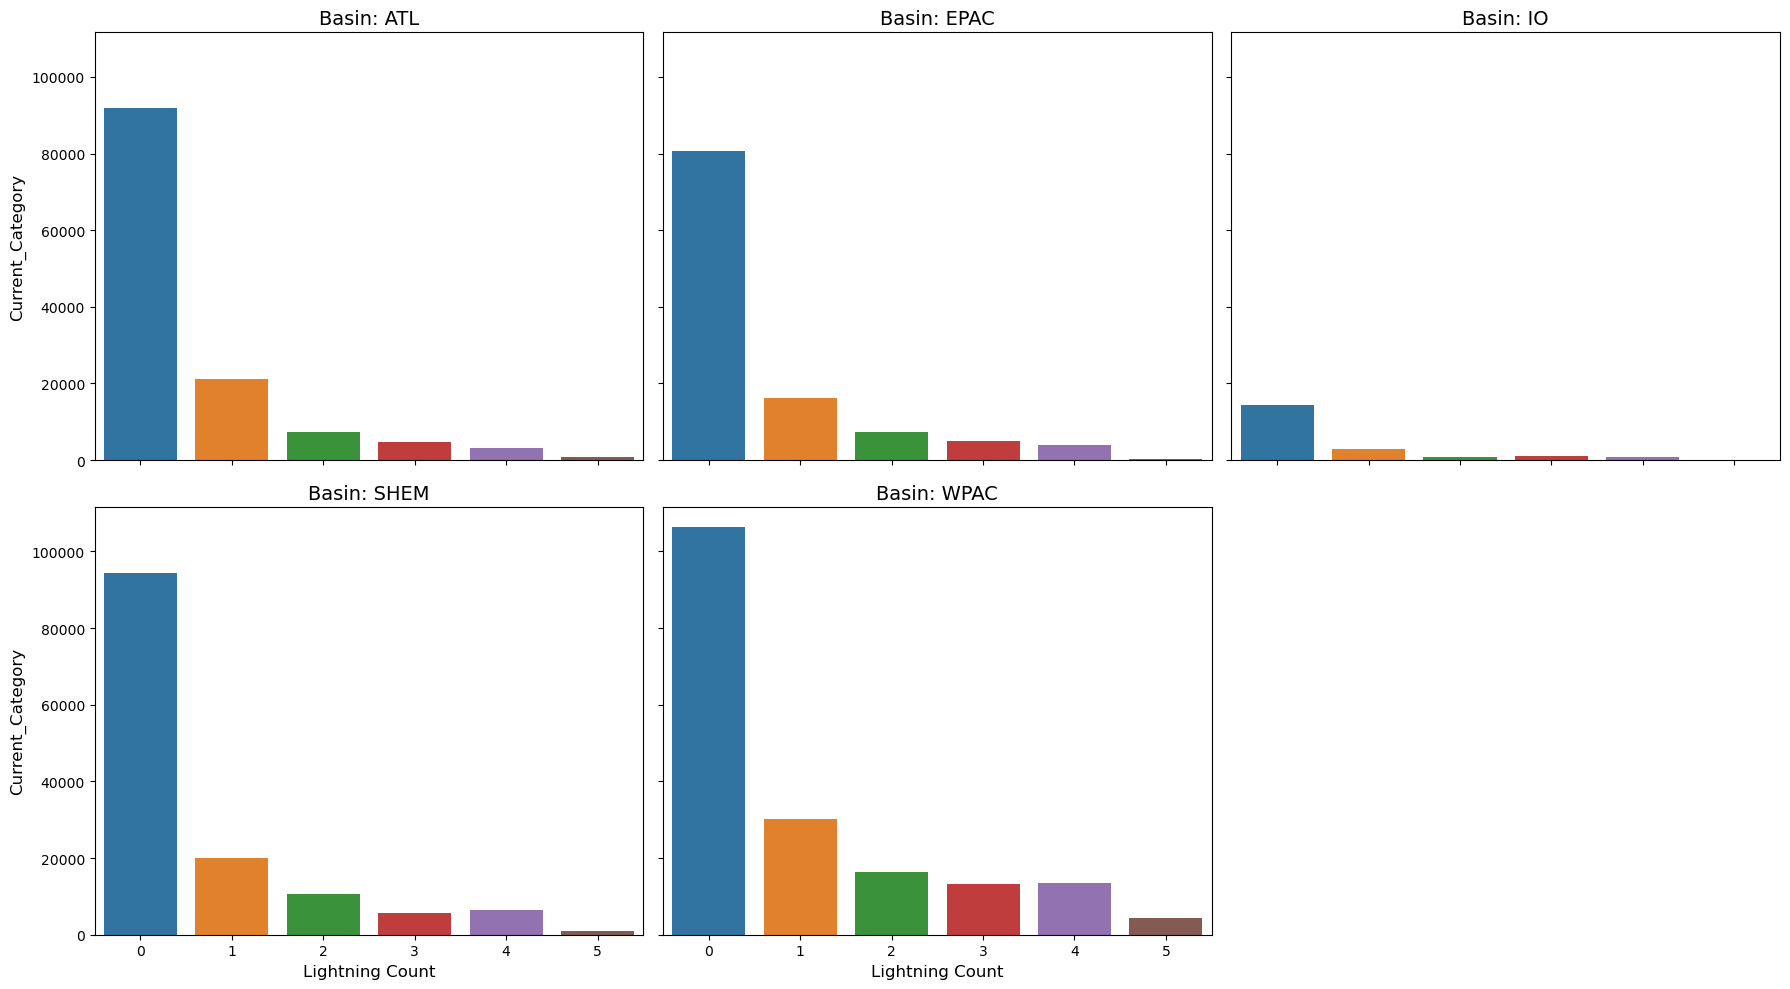

In [69]:
# Visualize by basin
# Filter out 'Unidentified' from Current_Category
filtered_data = rainband_data[rainband_data['Current_Category'] != 'Unidentified']

category_counts = filtered_data.groupby(['basin', 'Current_Category']).size().reset_index(name='count')

# Get unique basins
basins = category_counts['basin'].unique()

# Define a color palette for consistency across plots
unique_categories = category_counts['Current_Category'].unique()
palette = sns.color_palette("tab10", len(unique_categories))
category_colors = {category: palette[i] for i, category in enumerate(unique_categories)}

# Create a 2x3 grid of subplots
fig, axes = plt.subplots(2, 3, figsize=(18, 10), sharex=True, sharey=True)

# Flatten axes array for easier indexing
axes = axes.flatten()

# Loop through each basin and plot a bar chart
for i, basin in enumerate(basins):
    ax = axes[i]

    # Filter data for the current basin
    basin_data = category_counts[category_counts['basin'] == basin]

    # Plot bar chart
    sns.barplot(
        data=basin_data,
        y='count',
        x='Current_Category',
        ax=ax,
        hue='Current_Category',  # Assign hue
        palette=category_colors,
        legend=False  # Prevent duplicate legends in subplots
    )

    ax.set_title(f'Basin: {basin}', size=14)
    ax.set_xlabel('Lightning Count', size=12)
    ax.set_ylabel('Current_Category', size=12)

# Remove empty subplots if basins < 6
for j in range(len(basins), 6):
    fig.delaxes(axes[j])

# Adjust layout
plt.tight_layout()
plt.show()

Let's look at the number of lightning events for each intensification category over the different basins.

In [59]:
# Get counts per basin for the intensification categories
rainband_data.groupby('basin')['Intensification_Category'].value_counts()

basin  Intensification_Category
ATL    Neutral                     66248
       Intensifying                31368
       Weakening                   12520
       Unidentified                10752
       Rapidly Intensifying         6096
       Rapidly Weakening            1832
EPAC   Neutral                     44544
       Intensifying                27868
       Weakening                   16888
       Unidentified                11328
       Rapidly Intensifying         8260
       Rapidly Weakening            4772
IO     Neutral                      6816
       Intensifying                 6264
       Unidentified                 2304
       Weakening                    1948
       Rapidly Intensifying         1296
       Rapidly Weakening            1244
SHEM   Neutral                     46940
       Intensifying                39364
       Weakening                   17676
       Unidentified                14592
       Rapidly Intensifying        11416
       Rapidly Weakening 

Let's break it down by shear quadrant again.

In [61]:
# Get counts per basin, shear quad for the intensification categories
rainband_data.groupby(['basin', 'shear_quad'])['Intensification_Category'].value_counts()

basin  shear_quad  Intensification_Category
ATL    DL          Neutral                     16562
                   Intensifying                 7842
                   Weakening                    3130
                   Unidentified                 2688
                   Rapidly Intensifying         1524
                   Rapidly Weakening             458
       DR          Neutral                     16562
                   Intensifying                 7842
                   Weakening                    3130
                   Unidentified                 2688
                   Rapidly Intensifying         1524
                   Rapidly Weakening             458
       UL          Neutral                     16562
                   Intensifying                 7842
                   Weakening                    3130
                   Unidentified                 2688
                   Rapidly Intensifying         1524
                   Rapidly Weakening             458
  

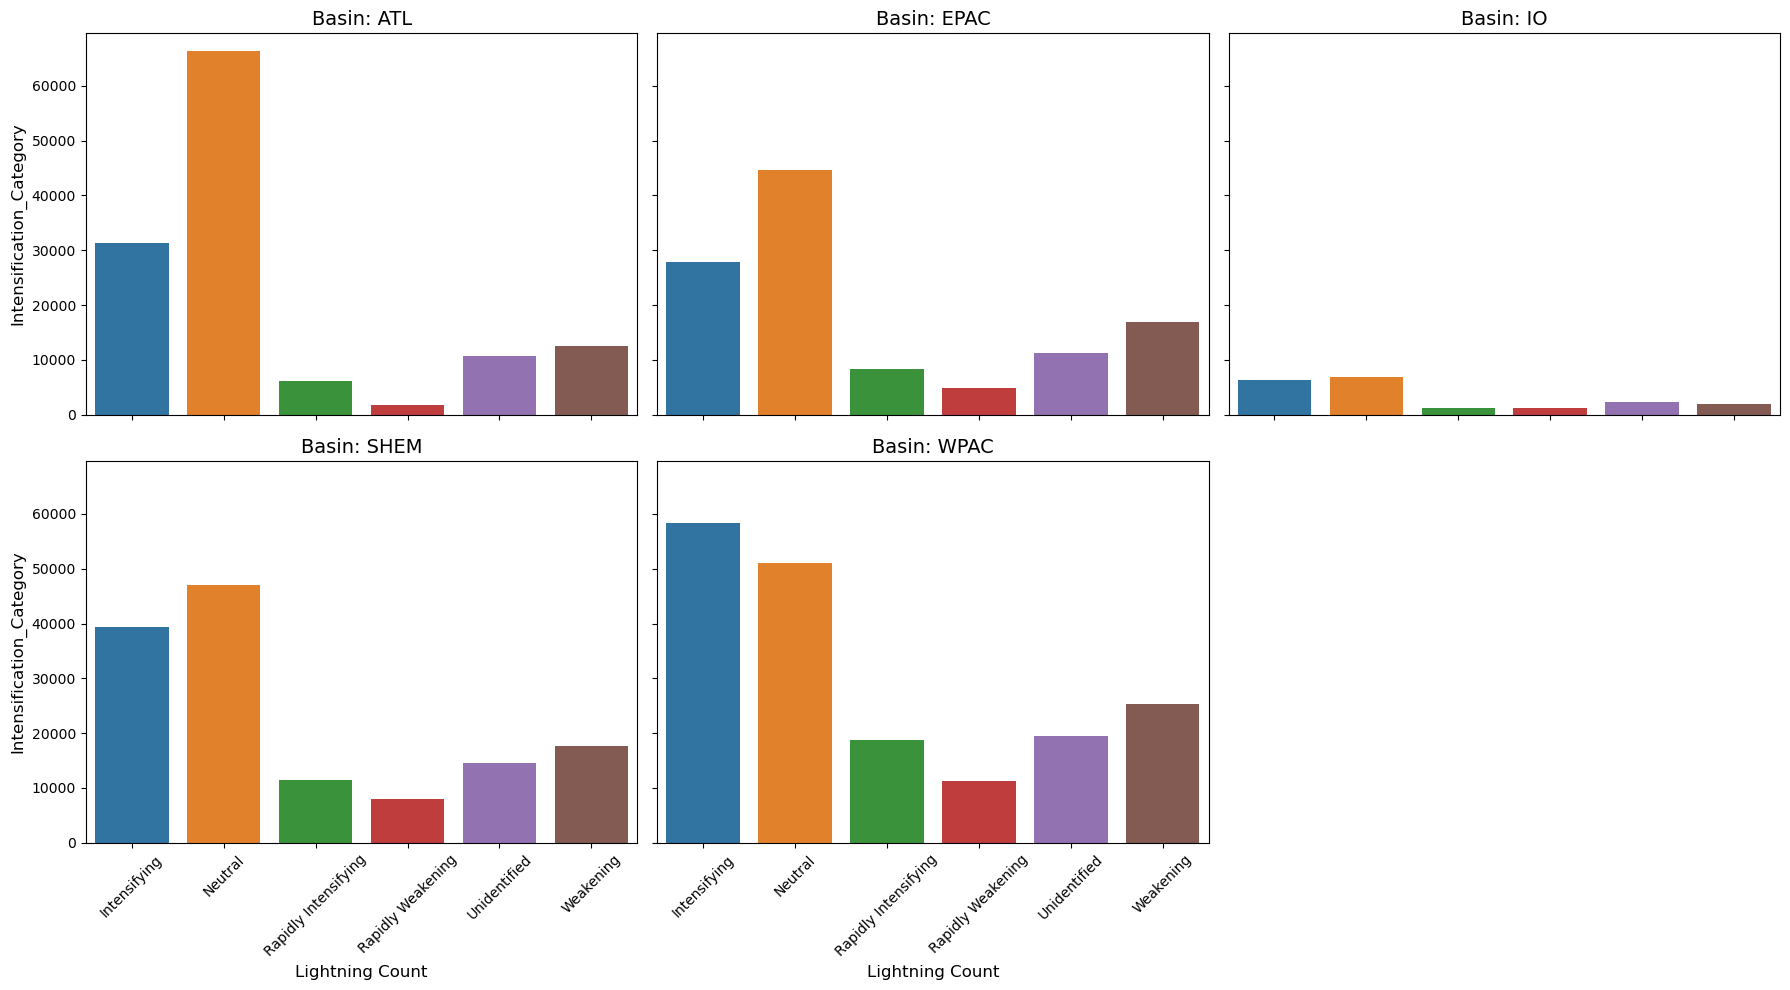

In [68]:
# Visualize by basin
# Group data and count occurrences of each intensification category per basin
category_counts = rainband_data.groupby(['basin', 'Intensification_Category']).size().reset_index(name='count')

# Get unique basins
basins = category_counts['basin'].unique()

# Define a color palette for consistency across plots
unique_categories = category_counts['Intensification_Category'].unique()
palette = sns.color_palette("tab10", len(unique_categories))
category_colors = {category: palette[i] for i, category in enumerate(unique_categories)}

# Create a 2x3 grid of subplots
fig, axes = plt.subplots(2, 3, figsize=(18, 10), sharex=True, sharey=True)

# Flatten axes array for easier indexing
axes = axes.flatten()

# Loop through each basin and plot a bar chart
for i, basin in enumerate(basins):
    ax = axes[i]

    # Filter data for the current basin
    basin_data = category_counts[category_counts['basin'] == basin]

    # Plot bar chart
    sns.barplot(
        data=basin_data,
        y='count',
        x='Intensification_Category',
        ax=ax,
        hue='Intensification_Category',  # Assign hue
        palette=category_colors,
        legend=False  # Prevent duplicate legends in subplots
    )

    ax.set_title(f'Basin: {basin}', size=14)
    ax.set_xlabel('Lightning Count', size=12)
    ax.set_ylabel('Intensification_Category', size=12)
    # Rotate x-axis labels
    for label in ax.get_xticklabels():
        label.set_rotation(45)

# Remove empty subplots if basins < 6
for j in range(len(basins), 6):
    fig.delaxes(axes[j])

# Adjust layout
plt.tight_layout()
plt.xticks(rotation=45)
plt.show()

We also look at the maximum 24-hour difference in wind speeds per basin.

In [73]:
# Get max 24-hour wind speed difference per basin
rainband_data.groupby(['basin'])['24_hour_knots_diff'].max(['24_hour_knots_diff'])

basin
ATL      65.0
EPAC    100.0
IO       80.0
SHEM     90.0
WPAC     80.0
Name: 24_hour_knots_diff, dtype: float64

We look at the distribution of lightning counts across basins, weighted by the number of storms per TC for better comparison.

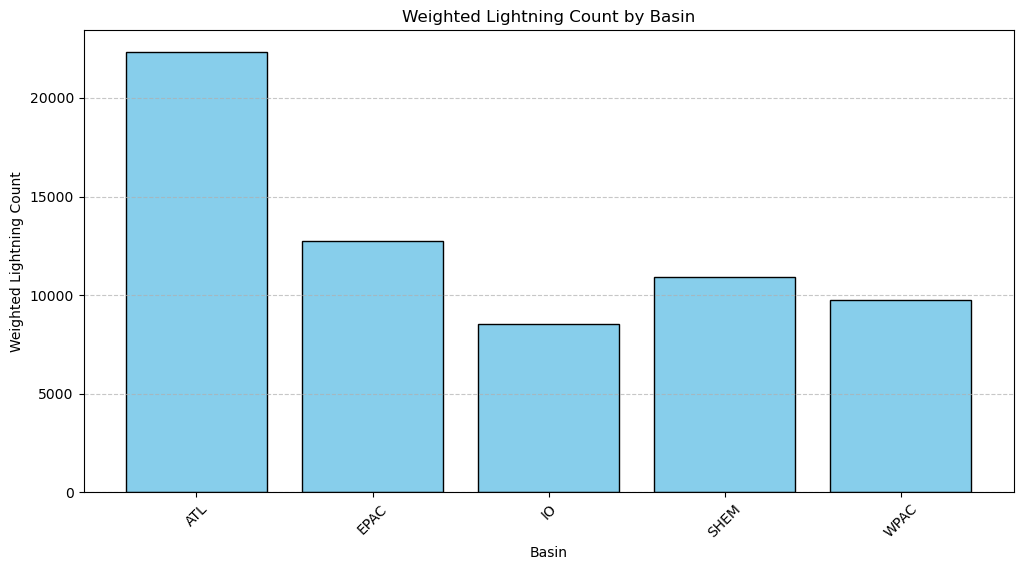

In [74]:
# Group by 'basin' and sum 'lightning count'
basin_lightning = rainband_data.groupby('basin')['lightning_count'].sum().reset_index()
# Merge to TC count per basin df
basin_lightning = basin_lightning.merge(rainband_basin_count, how="inner", on="basin")
# Calculate weighted lightning count
basin_lightning['weighted_count'] = basin_lightning['lightning_count']/basin_lightning['unique_tc_count']

# Plot
plt.figure(figsize=(12, 6))
plt.bar(basin_lightning['basin'], basin_lightning['weighted_count'], color='skyblue', edgecolor='black')

# Labels and title
plt.xlabel('Basin')
plt.ylabel('Weighted Lightning Count')
plt.title('Weighted Lightning Count by Basin')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Show plot
plt.show()

Let's take a look at the distribution of lightning counts across the different basins colored by intensification stage and current category. We log transform the lightning counts to get a better look.

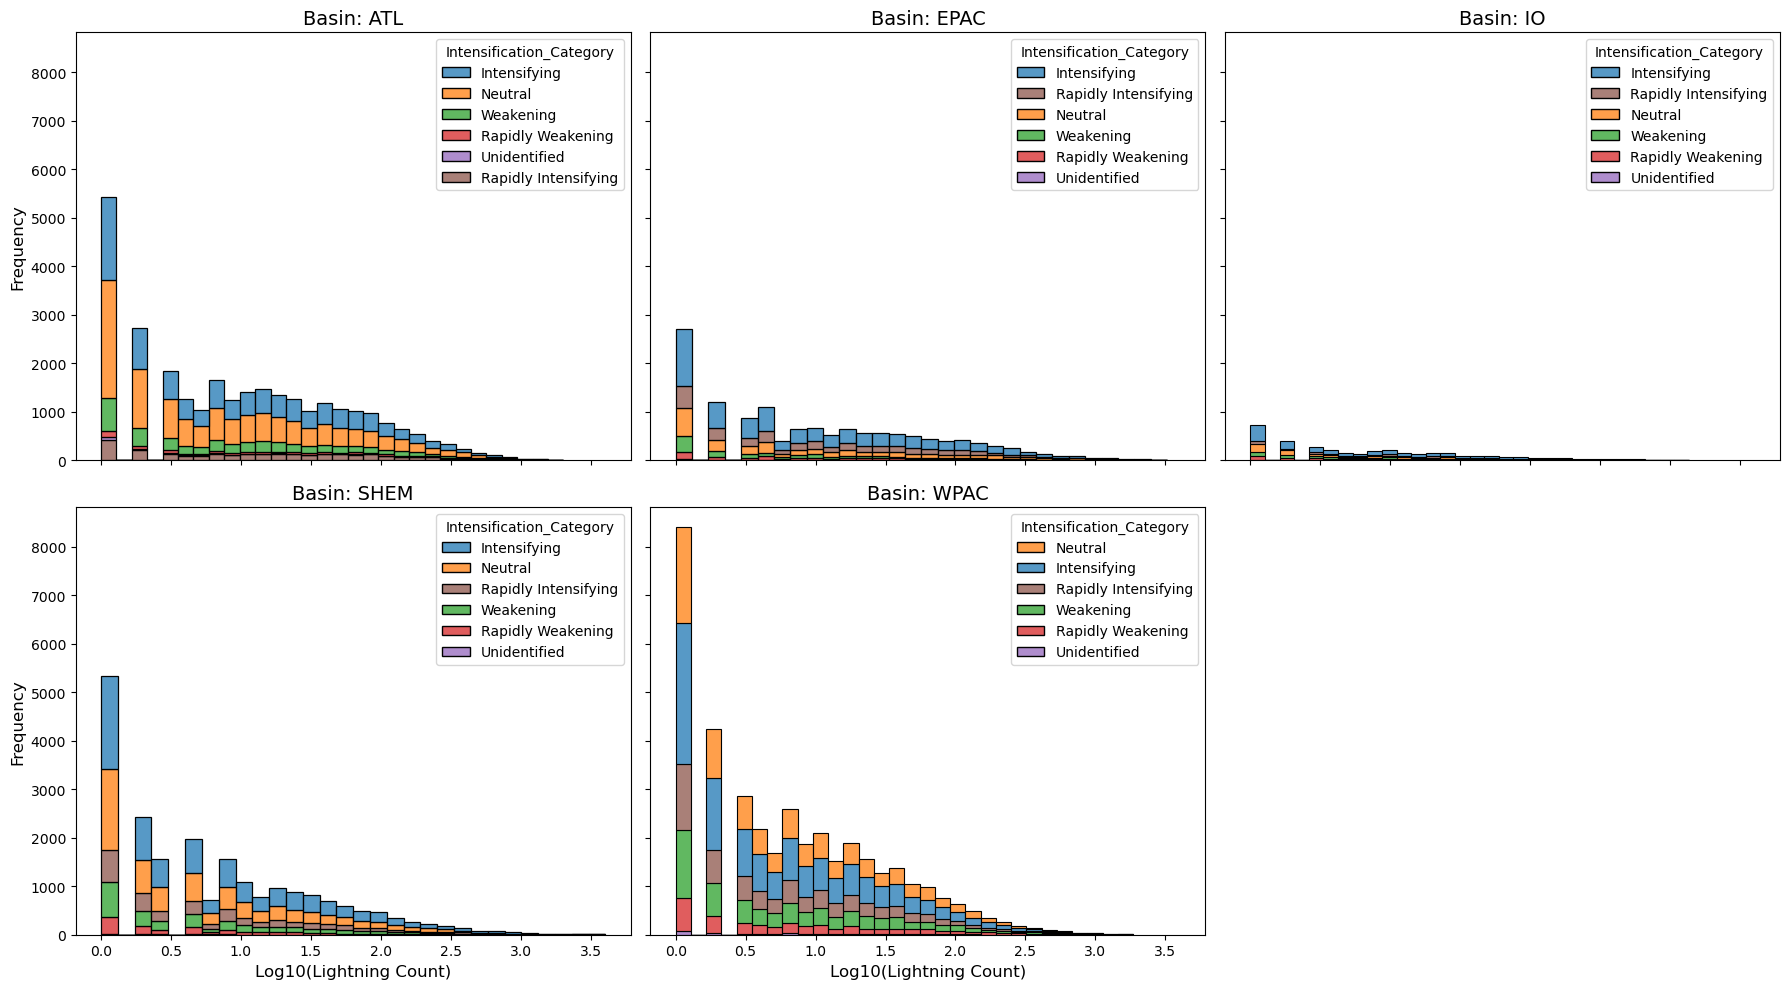

In [75]:
# Intensification stage
# Filter out zero lightning counts
filtered_data = rainband_data[rainband_data['lightning_count'] > 0].copy()

# Log-transform the lightning count
filtered_data['log_lightning_count'] = np.log10(filtered_data['lightning_count'])

# Get unique basins
basins = filtered_data['basin'].unique()

# Get unique categories and assign consistent colors
unique_categories = filtered_data['Intensification_Category'].unique()
palette = sns.color_palette("tab10", len(unique_categories))  # Using a fixed palette
category_colors = {category: palette[i] for i, category in enumerate(unique_categories)}

# Create a 2x3 grid of subplots
fig, axes = plt.subplots(2, 3, figsize=(18, 10), sharex=True, sharey=True)

# Flatten axes array for easier indexing
axes = axes.flatten()

# Loop through each basin and plot
for i, basin in enumerate(basins):
    ax = axes[i]

    # Filter data for the current basin
    basin_data = filtered_data[filtered_data['basin'] == basin]

    # Plot stacked histogram with consistent colors
    sns.histplot(
        data=basin_data,
        x='log_lightning_count',
        hue='Intensification_Category',
        multiple='stack',  # Stacked bars
        bins=30,
        ax=ax,
        palette=category_colors  # Apply consistent colors
    )

    ax.set_title(f'Basin: {basin}', size=14)
    ax.set_xlabel('Log10(Lightning Count)', size=12)
    ax.set_ylabel('Frequency', size=12)

# Remove empty subplots if basins < 6
for j in range(len(basins), 6):
    fig.delaxes(axes[j])

# Adjust layout
plt.tight_layout()
plt.show()

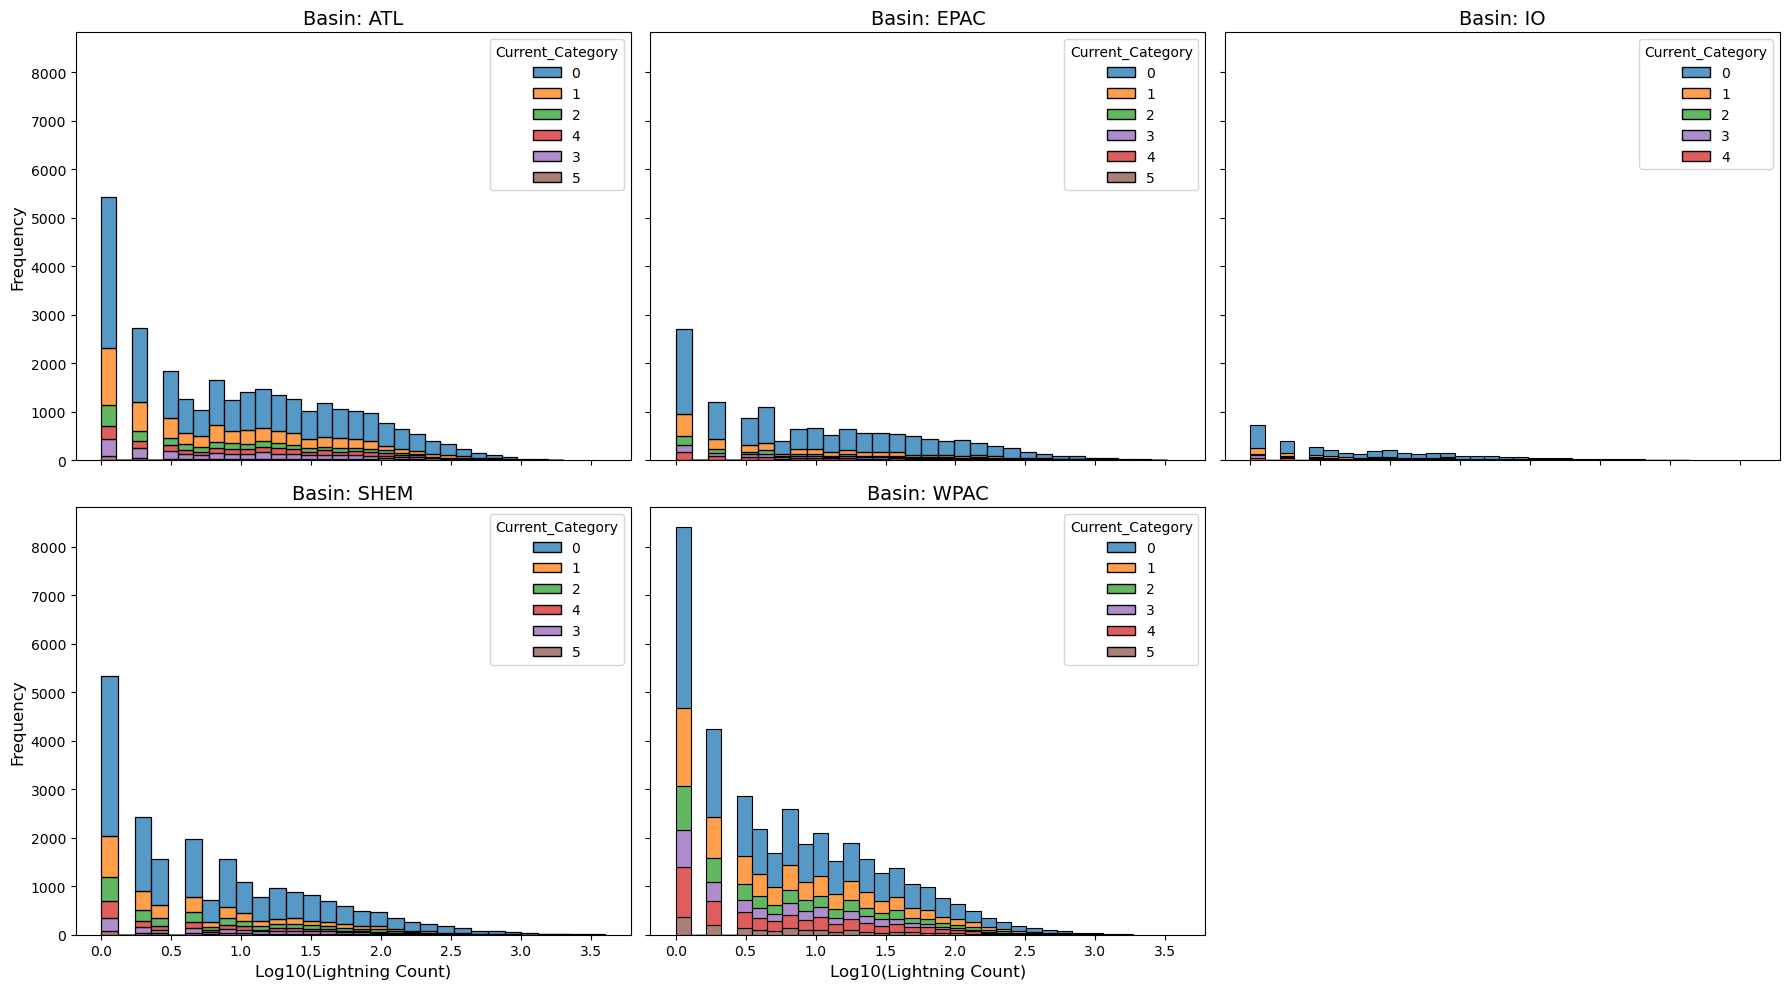

In [76]:
# Current Category
# Filter out zero lightning counts
filtered_data = rainband_data[rainband_data['lightning_count'] > 0].copy()

# Log-transform the lightning count
filtered_data['log_lightning_count'] = np.log10(filtered_data['lightning_count'])

# Get unique basins
basins = filtered_data['basin'].unique()

# Get unique categories and assign consistent colors
unique_categories = filtered_data['Current_Category'].unique()
palette = sns.color_palette("tab10", len(unique_categories))  # Using a fixed palette
category_colors = {category: palette[i] for i, category in enumerate(unique_categories)}

# Create a 2x3 grid of subplots
fig, axes = plt.subplots(2, 3, figsize=(18, 10), sharex=True, sharey=True)

# Flatten axes array for easier indexing
axes = axes.flatten()

# Loop through each basin and plot
for i, basin in enumerate(basins):
    ax = axes[i]

    # Filter data for the current basin
    basin_data = filtered_data[filtered_data['basin'] == basin]

    # Plot stacked histogram with consistent colors
    sns.histplot(
        data=basin_data,
        x='log_lightning_count',
        hue='Current_Category',
        multiple='stack',  # Stacked bars
        bins=30,
        ax=ax,
        palette=category_colors  # Apply consistent colors
    )

    ax.set_title(f'Basin: {basin}', size=14)
    ax.set_xlabel('Log10(Lightning Count)', size=12)
    ax.set_ylabel('Frequency', size=12)

# Remove empty subplots if basins < 6
for j in range(len(basins), 6):
    fig.delaxes(axes[j])

# Adjust layout
plt.tight_layout()
plt.show()

### Shear Quadrant Rainband Basin Comparison
Let's take a closer look at the rainband data broken down into shear quadrants for each basin.

Start by creating plotting functions.

In [90]:
def plot_log_dist_intensification(dataset):
    filtered_data = dataset[dataset['lightning_count'] > 0].copy()

    # Log-transform the lightning count
    filtered_data['log_lightning_count'] = np.log10(filtered_data['lightning_count'])

    # Get unique basins
    shear_quad = filtered_data['shear_quad'].unique()

    # Get unique categories and assign consistent colors
    unique_categories = filtered_data['Intensification_Category'].unique()
    palette = sns.color_palette("tab10", len(unique_categories))  # Using a fixed palette
    category_colors = {category: palette[i] for i, category in enumerate(unique_categories)}

    # Create a 2x2 grid of subplots
    fig, axes = plt.subplots(2, 2, figsize=(18, 10), sharex=True, sharey=True)

    # Flatten axes array for easier indexing
    axes = axes.flatten()

    # Loop through each basin and plot
    for i, quad in enumerate(shear_quad):
        ax = axes[i]

        # Filter data for the current basin
        shear_data = filtered_data[filtered_data['shear_quad'] == quad]

        # Plot stacked histogram with consistent colors
        sns.histplot(
            data=shear_data,
            x='log_lightning_count',
            hue='Intensification_Category',
            multiple='stack',  # Stacked bars
            bins=30,
            ax=ax,
            palette=category_colors  # Apply consistent colors
        )

        ax.set_title(f'Shear Quadrant: {quad}', size=14)
        ax.set_xlabel('Log10(Lightning Count)', size=12)
        ax.set_ylabel('Frequency', size=12)

    # Remove empty subplots if basins < 6
    for j in range(len(shear_quad), 4):
        fig.delaxes(axes[j])

    # Adjust layout
    plt.tight_layout()
    plt.show()

In [92]:
def plot_log_dist_currentcategory(dataset):
    filtered_data = dataset[dataset['lightning_count'] > 0].copy()

    # Log-transform the lightning count
    filtered_data['log_lightning_count'] = np.log10(filtered_data['lightning_count'])

    # Get unique basins
    shear_quad = filtered_data['shear_quad'].unique()

    # Get unique categories and assign consistent colors
    unique_categories = filtered_data['Current_Category'].unique()
    palette = sns.color_palette("tab10", len(unique_categories))  # Using a fixed palette
    category_colors = {category: palette[i] for i, category in enumerate(unique_categories)}

    # Create a 2x2 grid of subplots
    fig, axes = plt.subplots(2, 2, figsize=(18, 10), sharex=True, sharey=True)

    # Flatten axes array for easier indexing
    axes = axes.flatten()

    # Loop through each basin and plot
    for i, quad in enumerate(shear_quad):
        ax = axes[i]

        # Filter data for the current basin
        shear_data = filtered_data[filtered_data['shear_quad'] == quad]

        # Plot stacked histogram with consistent colors
        sns.histplot(
            data=shear_data,
            x='log_lightning_count',
            hue='Current_Category',
            multiple='stack',  # Stacked bars
            bins=30,
            ax=ax,
            palette=category_colors  # Apply consistent colors
        )

        ax.set_title(f'Shear Quadrant: {quad}', size=14)
        ax.set_xlabel('Log10(Lightning Count)', size=12)
        ax.set_ylabel('Frequency', size=12)

    # Remove empty subplots if basins < 6
    for j in range(len(shear_quad), 4):
        fig.delaxes(axes[j])

    # Adjust layout
    plt.tight_layout()
    plt.show()

#### ATL
Start by filtering the rainband data for ATL basin.

In [ ]:
# Filter for ATL
atl_rainband = rainband_data[rainband_data["basin"]=="ATL"]

Plot the log lightning count distribution per shear quadrant, colored by intensification stage.

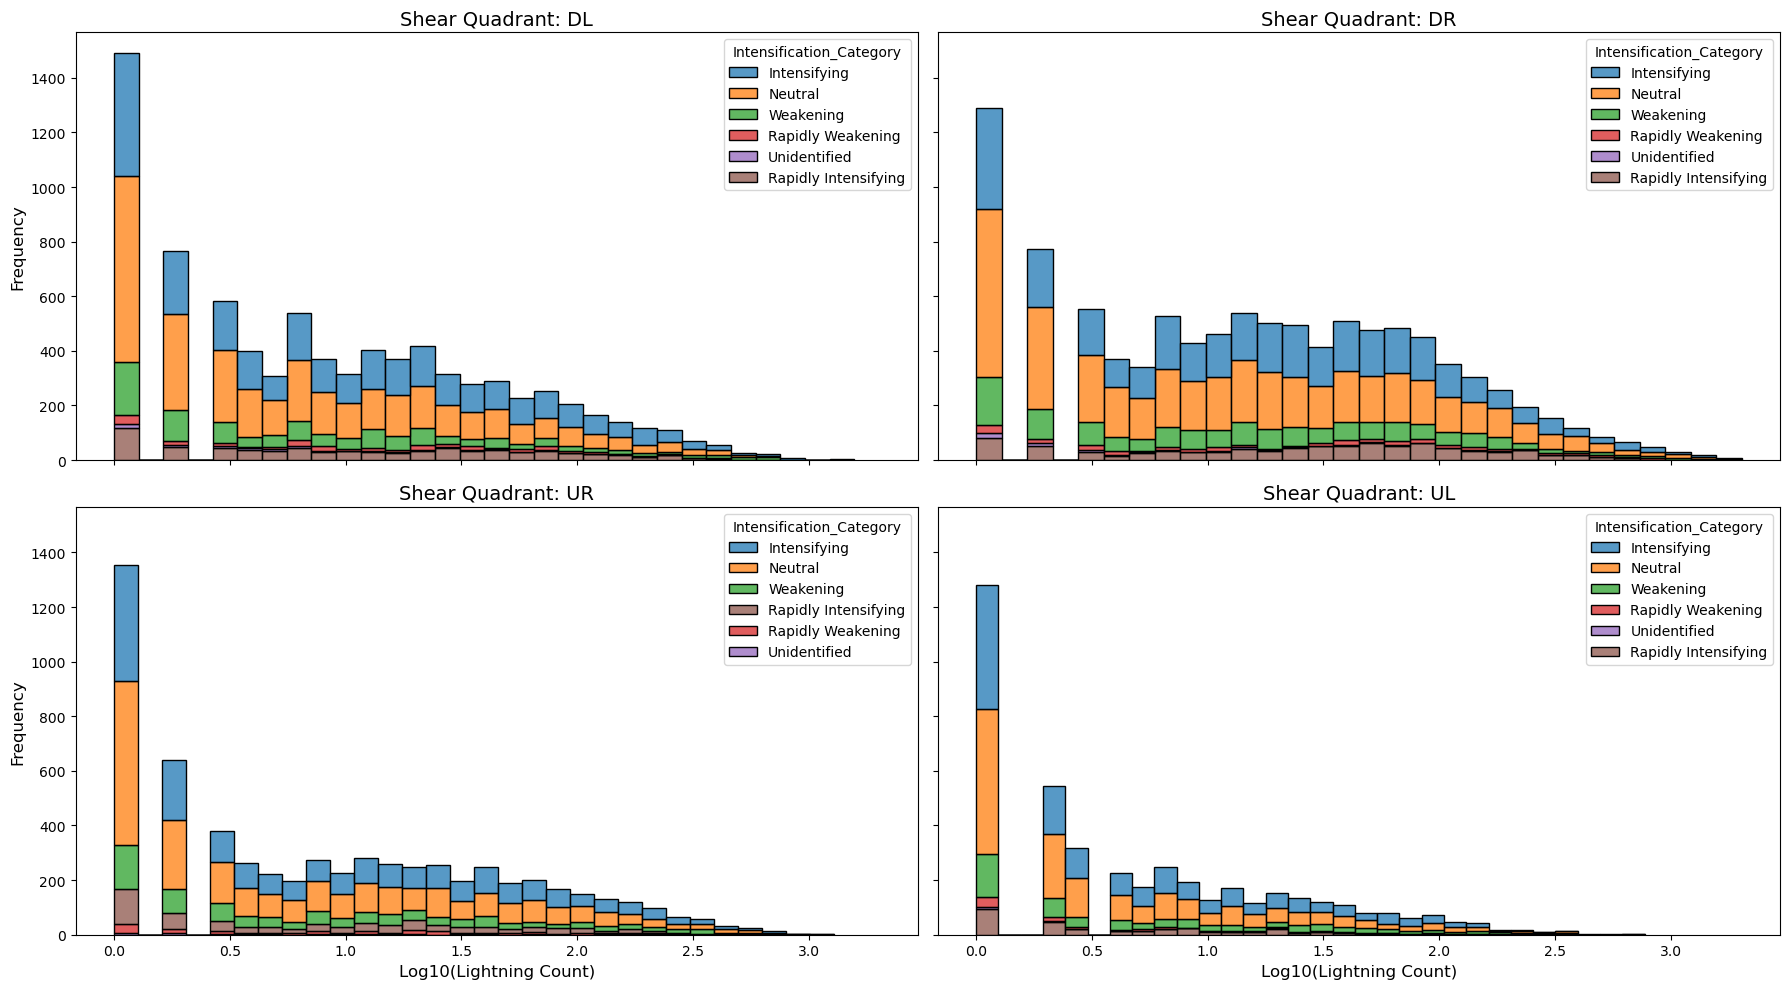

In [93]:
plot_log_dist_intensification(atl_rainband)

Do the same for current category.

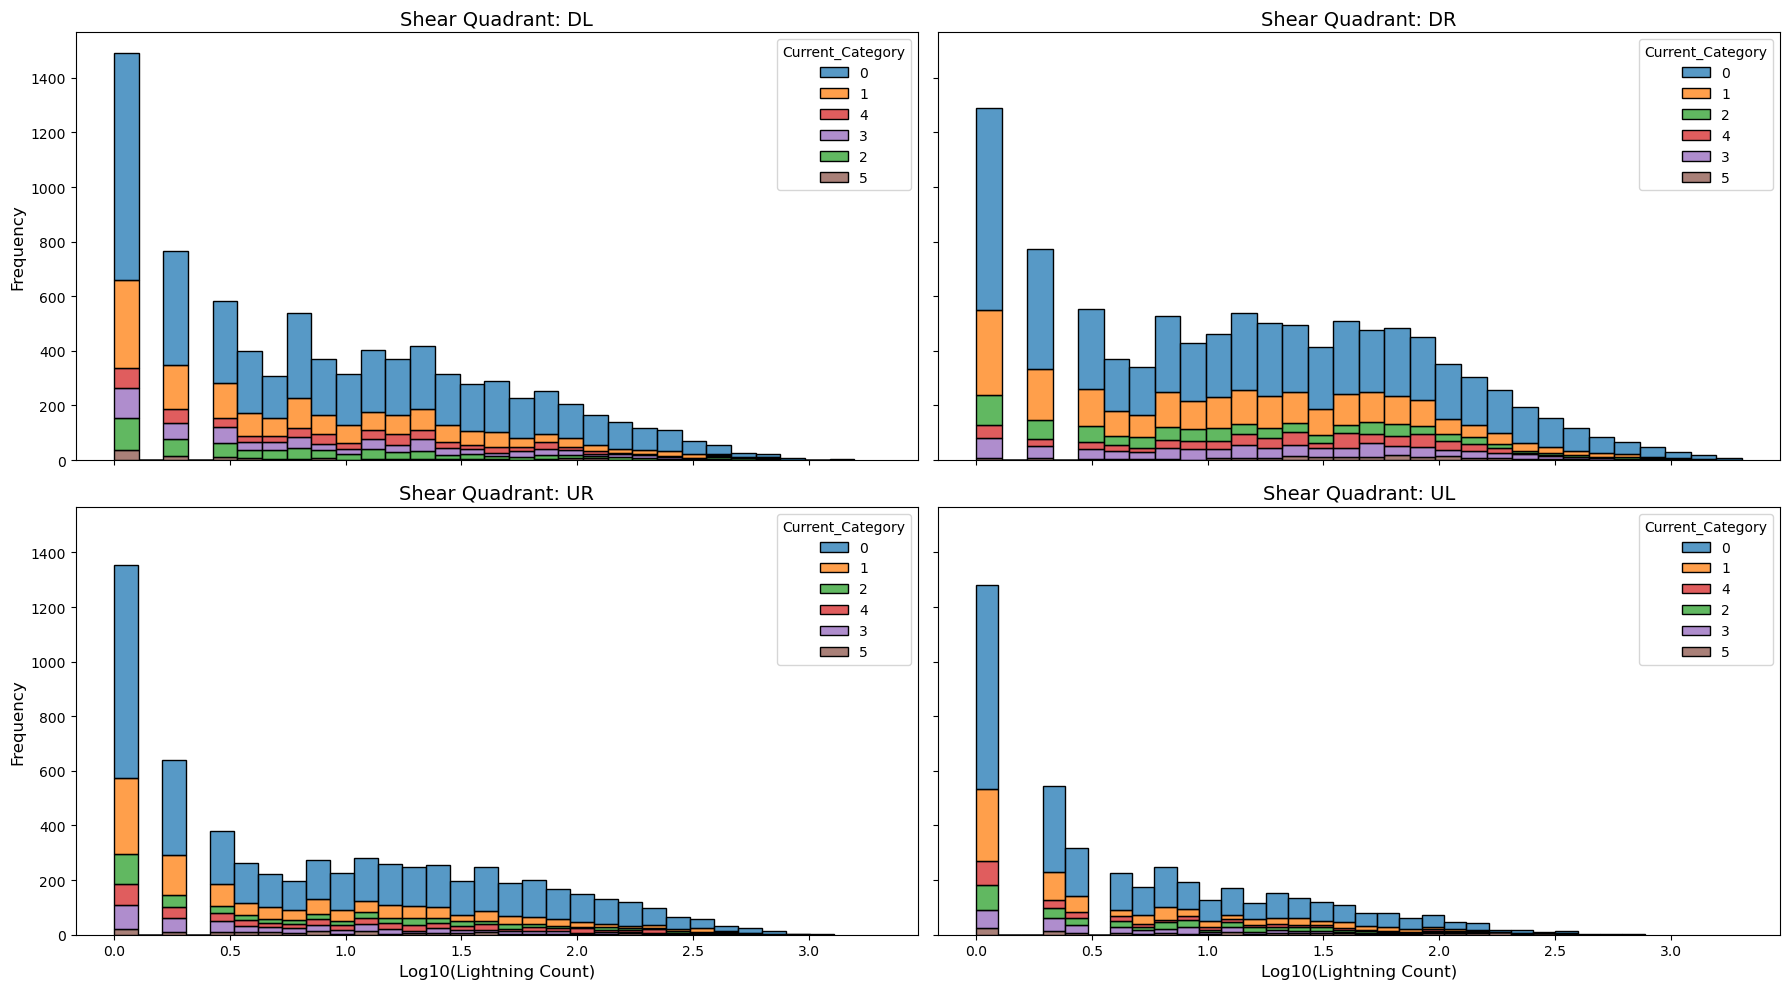

In [94]:
plot_log_dist_currentcategory(atl_rainband)

#### EPAC
Start by filtering the rainband data for EPAC basin.

In [80]:
# Filter for EPAC
epac_rainband = rainband_data[rainband_data["basin"]=="EPAC"]

Plot the log lightning count distribution per shear quadrant, colored by intensification stage.

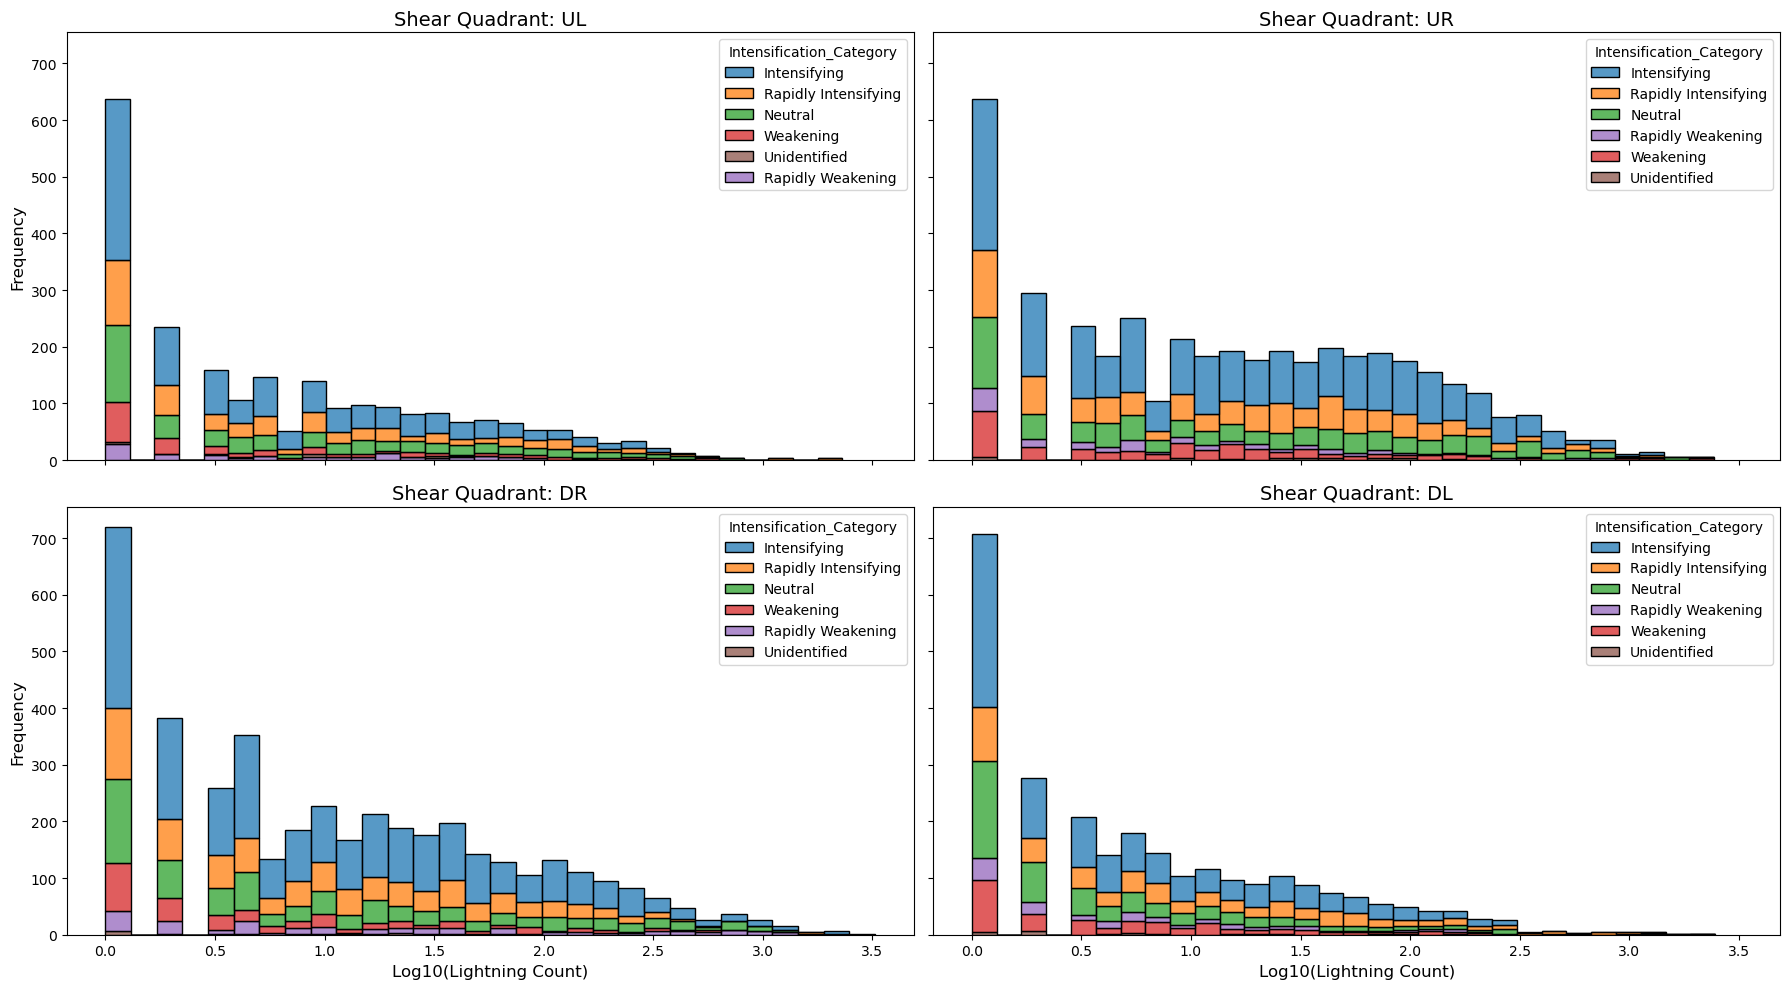

In [95]:
plot_log_dist_intensification(epac_rainband)

Do the same for current category.

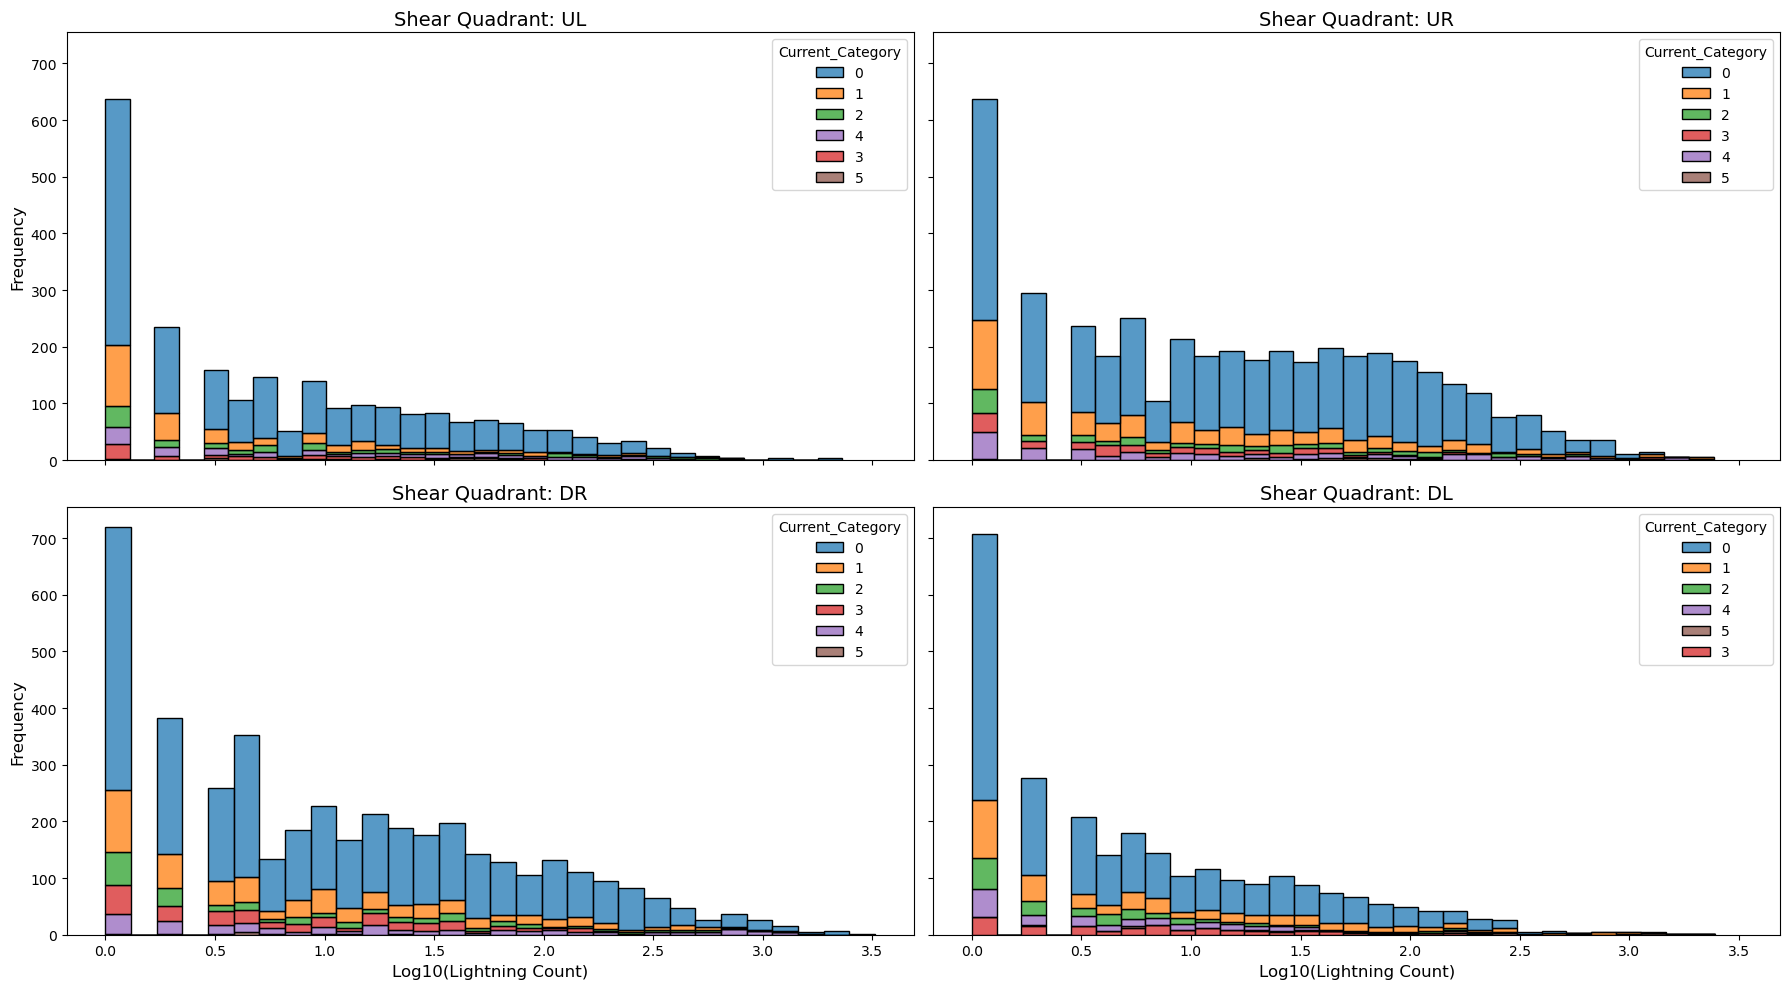

In [96]:
plot_log_dist_currentcategory(epac_rainband)

#### IO
Start by filtering the rainband data for IO basin.

In [83]:
# Filter for IO
io_rainband = rainband_data[rainband_data["basin"]=="IO"]

Plot the log lightning count distribution per shear quadrant, colored by intensification stage.

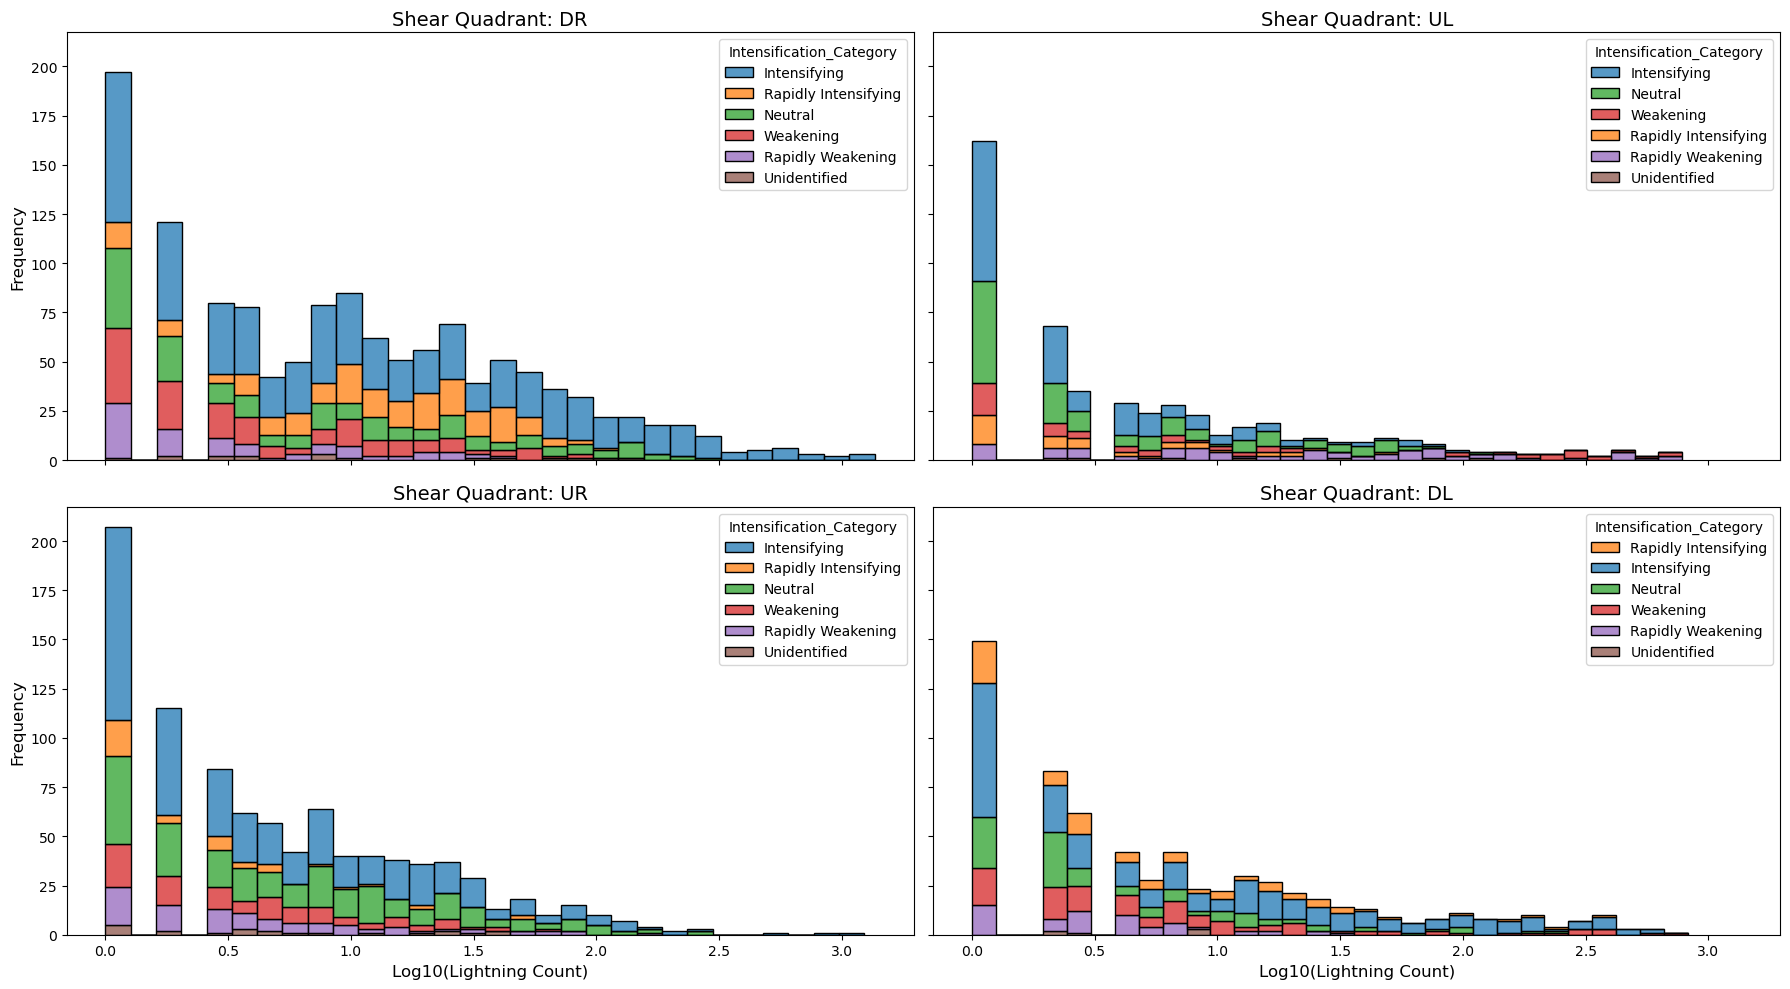

In [97]:
plot_log_dist_intensification(io_rainband)

Do the same for current category.

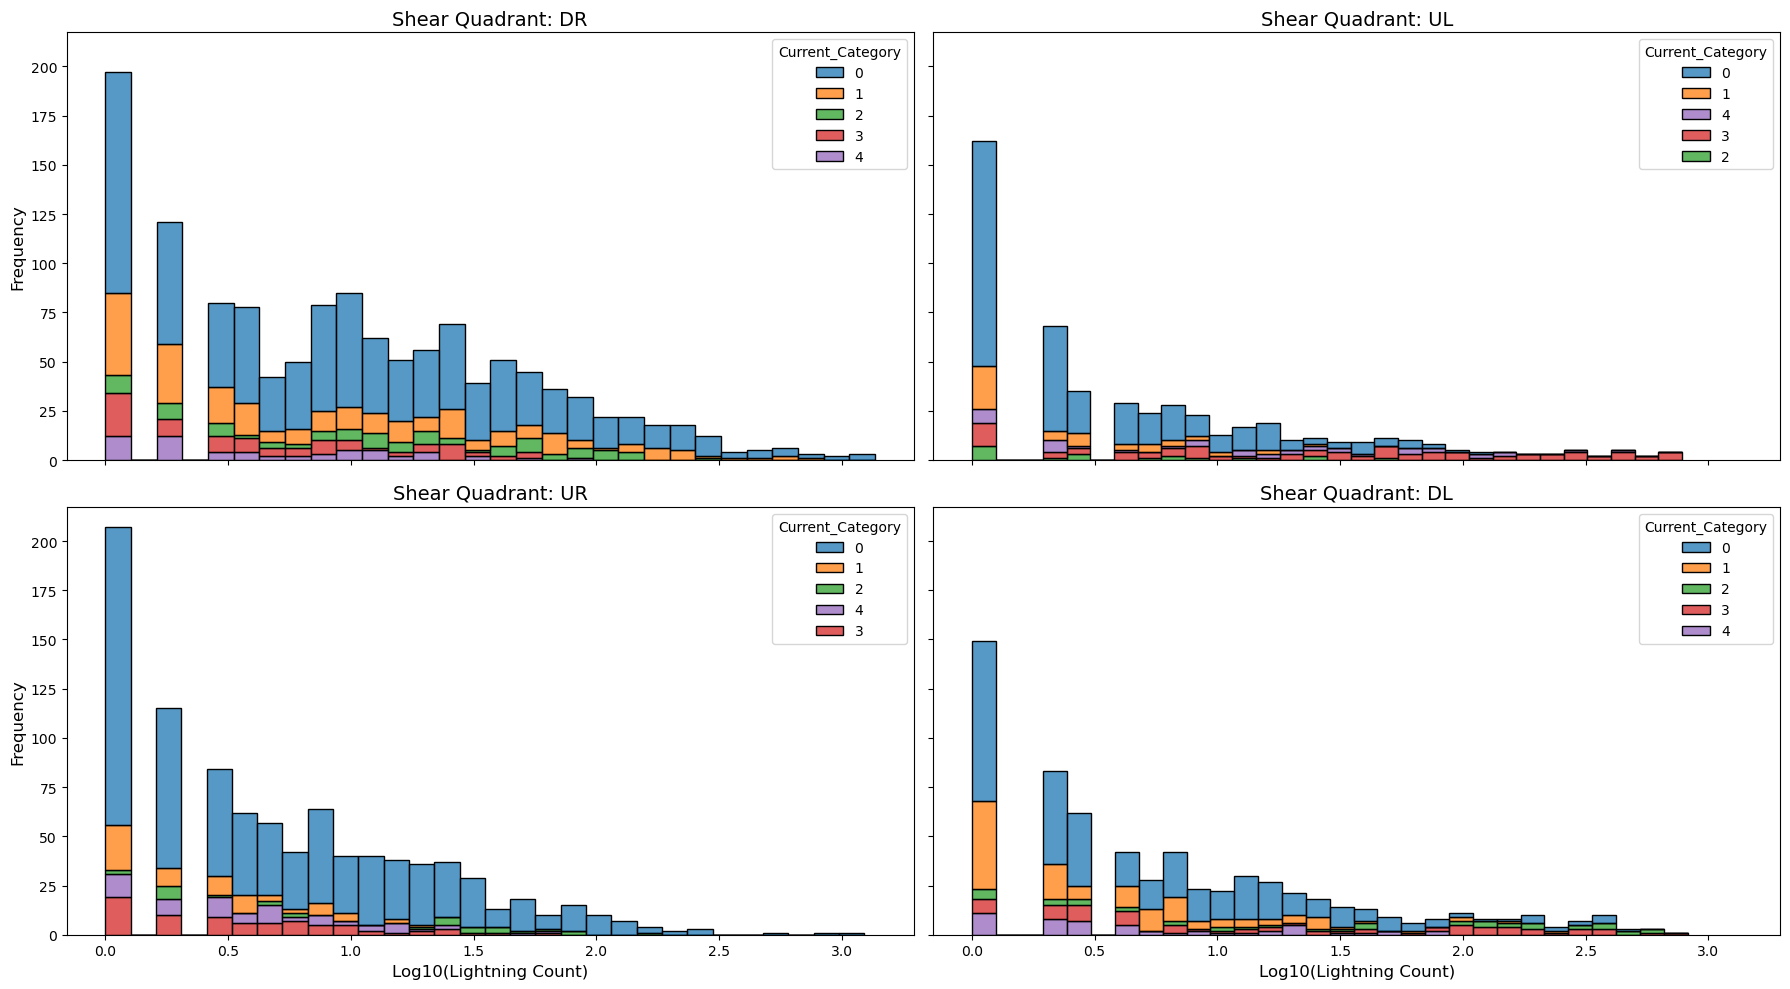

In [98]:
plot_log_dist_currentcategory(io_rainband)

#### SHEM
Start by filtering the rainband data for SHEM basin.

In [86]:
# Filter for SHEM
shem_rainband = rainband_data[rainband_data["basin"]=="SHEM"]

Plot the log lightning count distribution per shear quadrant, colored by intensification stage.

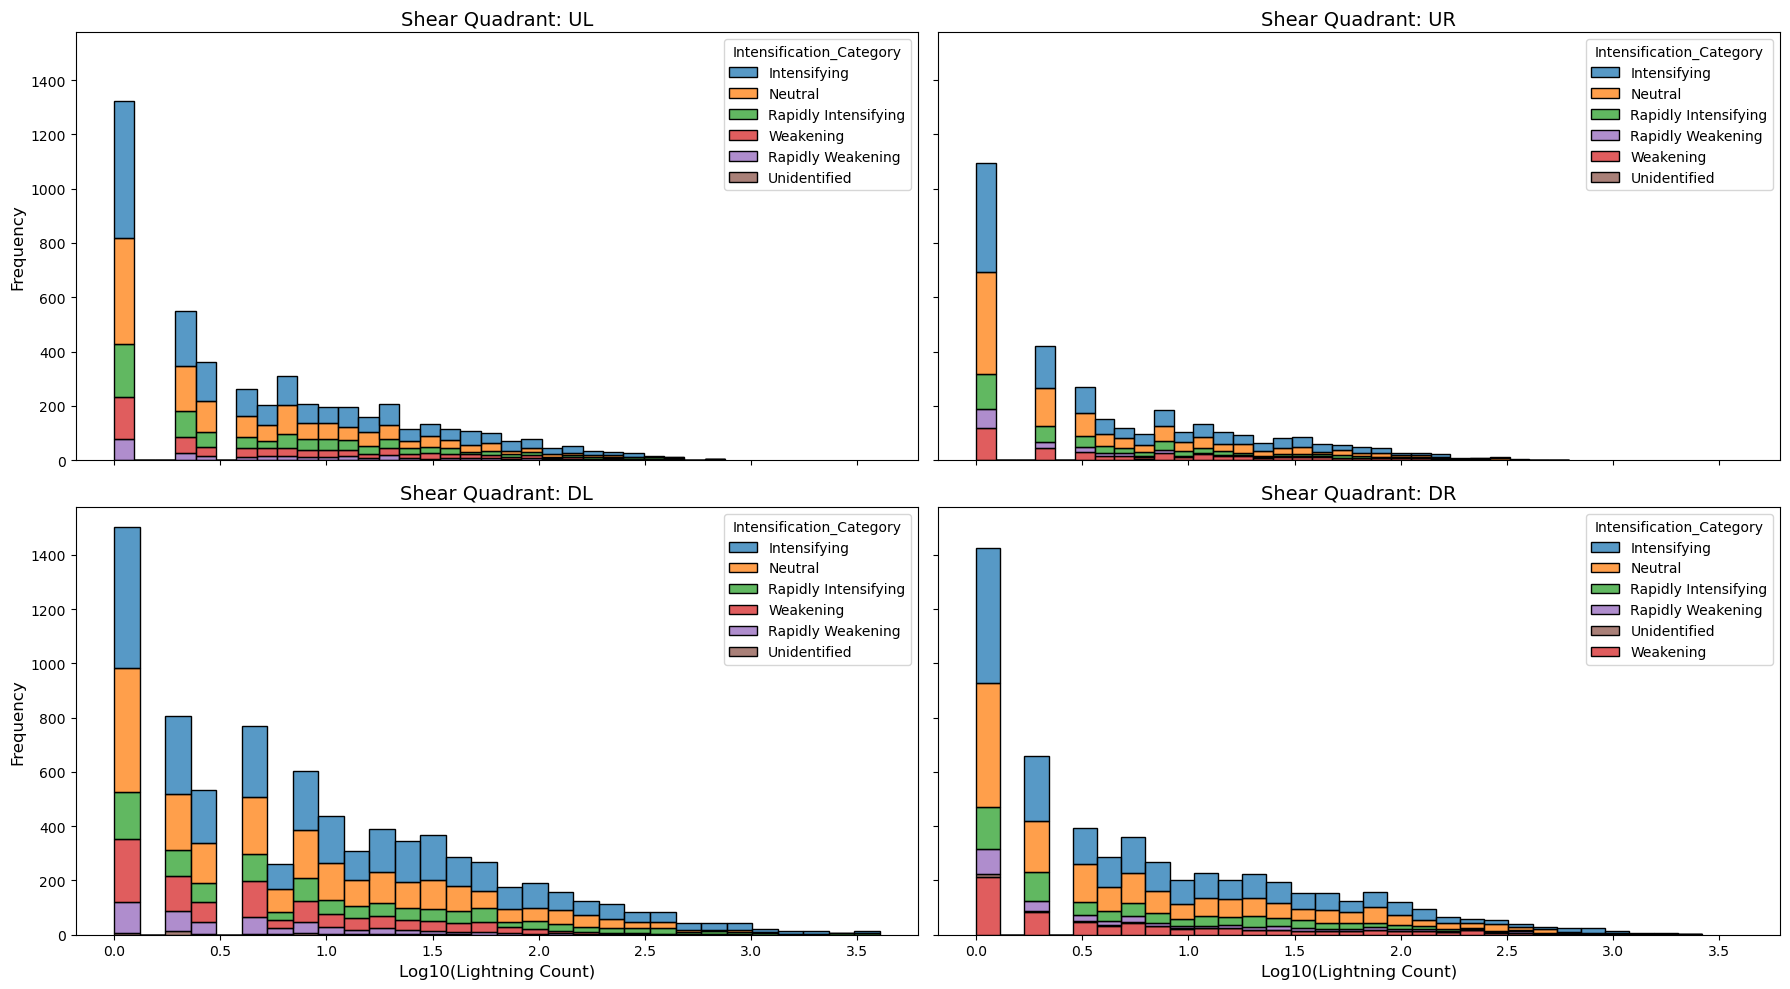

In [99]:
plot_log_dist_intensification(shem_rainband)

Do the same for current category.

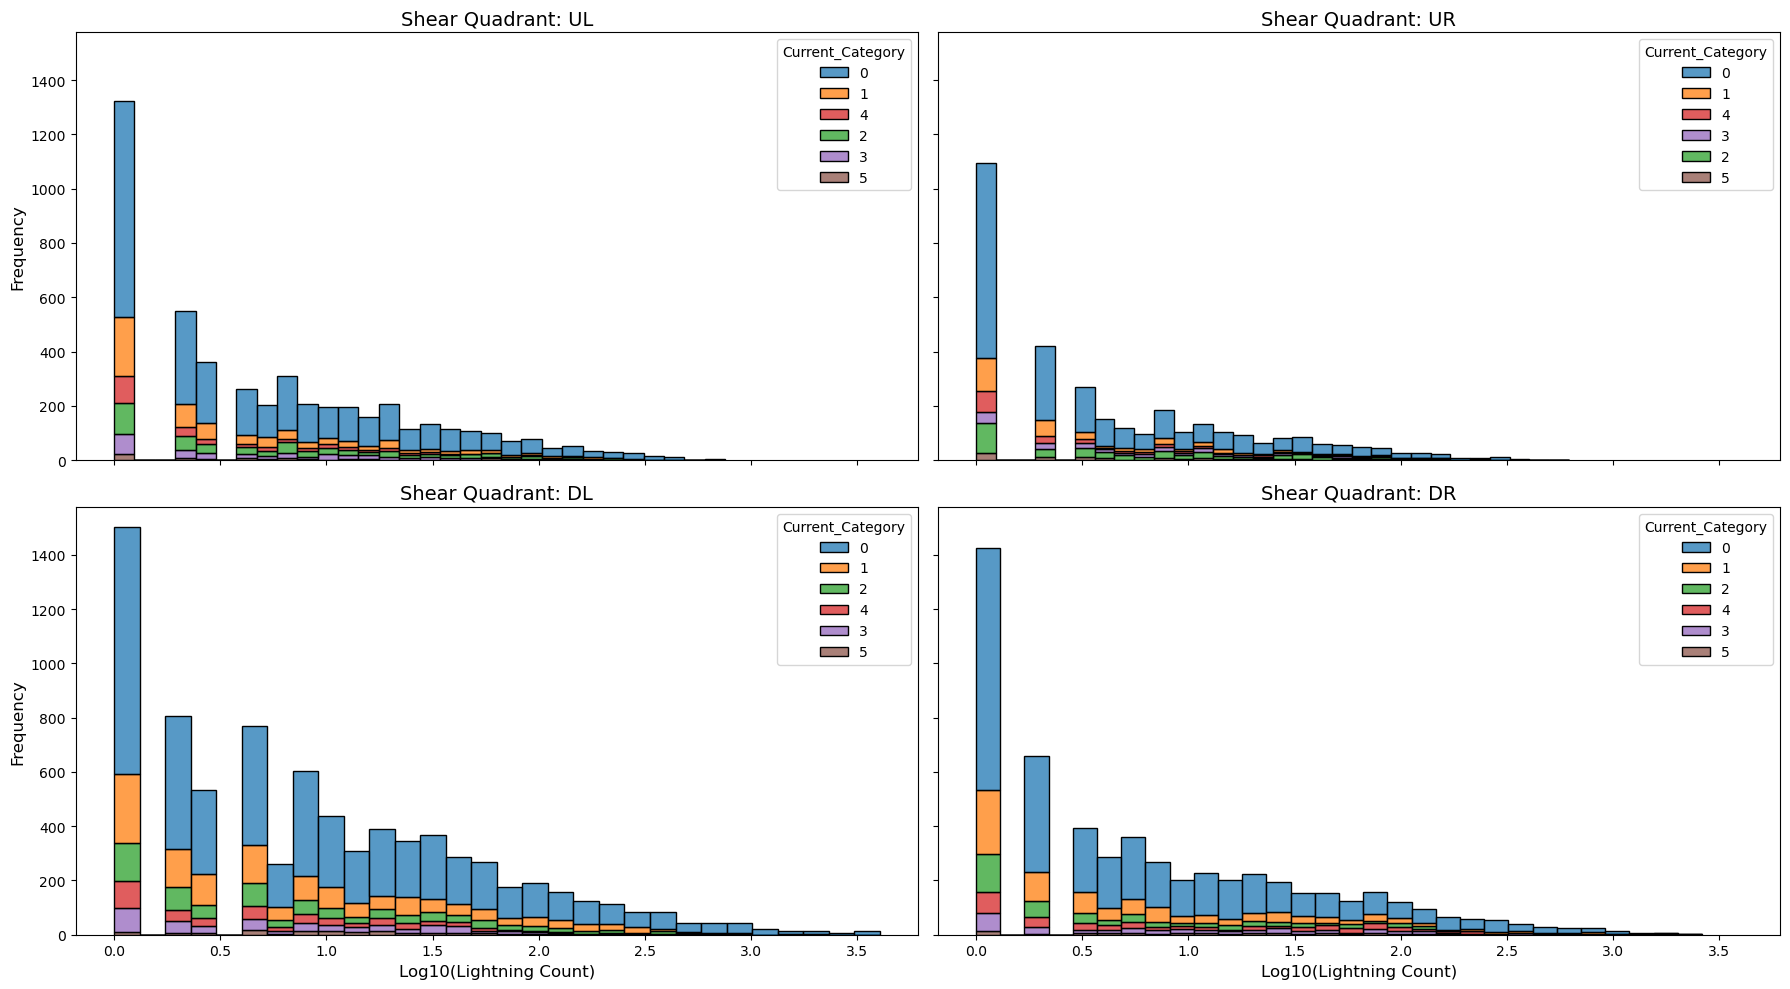

In [ ]:
plot_log_dist_currentcategory(shem_rainband)

#### WPAC
Start by filtering the rainband data for WPAC basin.

In [100]:
# Filter for WPAC
wpac_rainband = rainband_data[rainband_data["basin"]=="WPAC"]

Plot the log lightning count distribution per shear quadrant, colored by intensification stage.

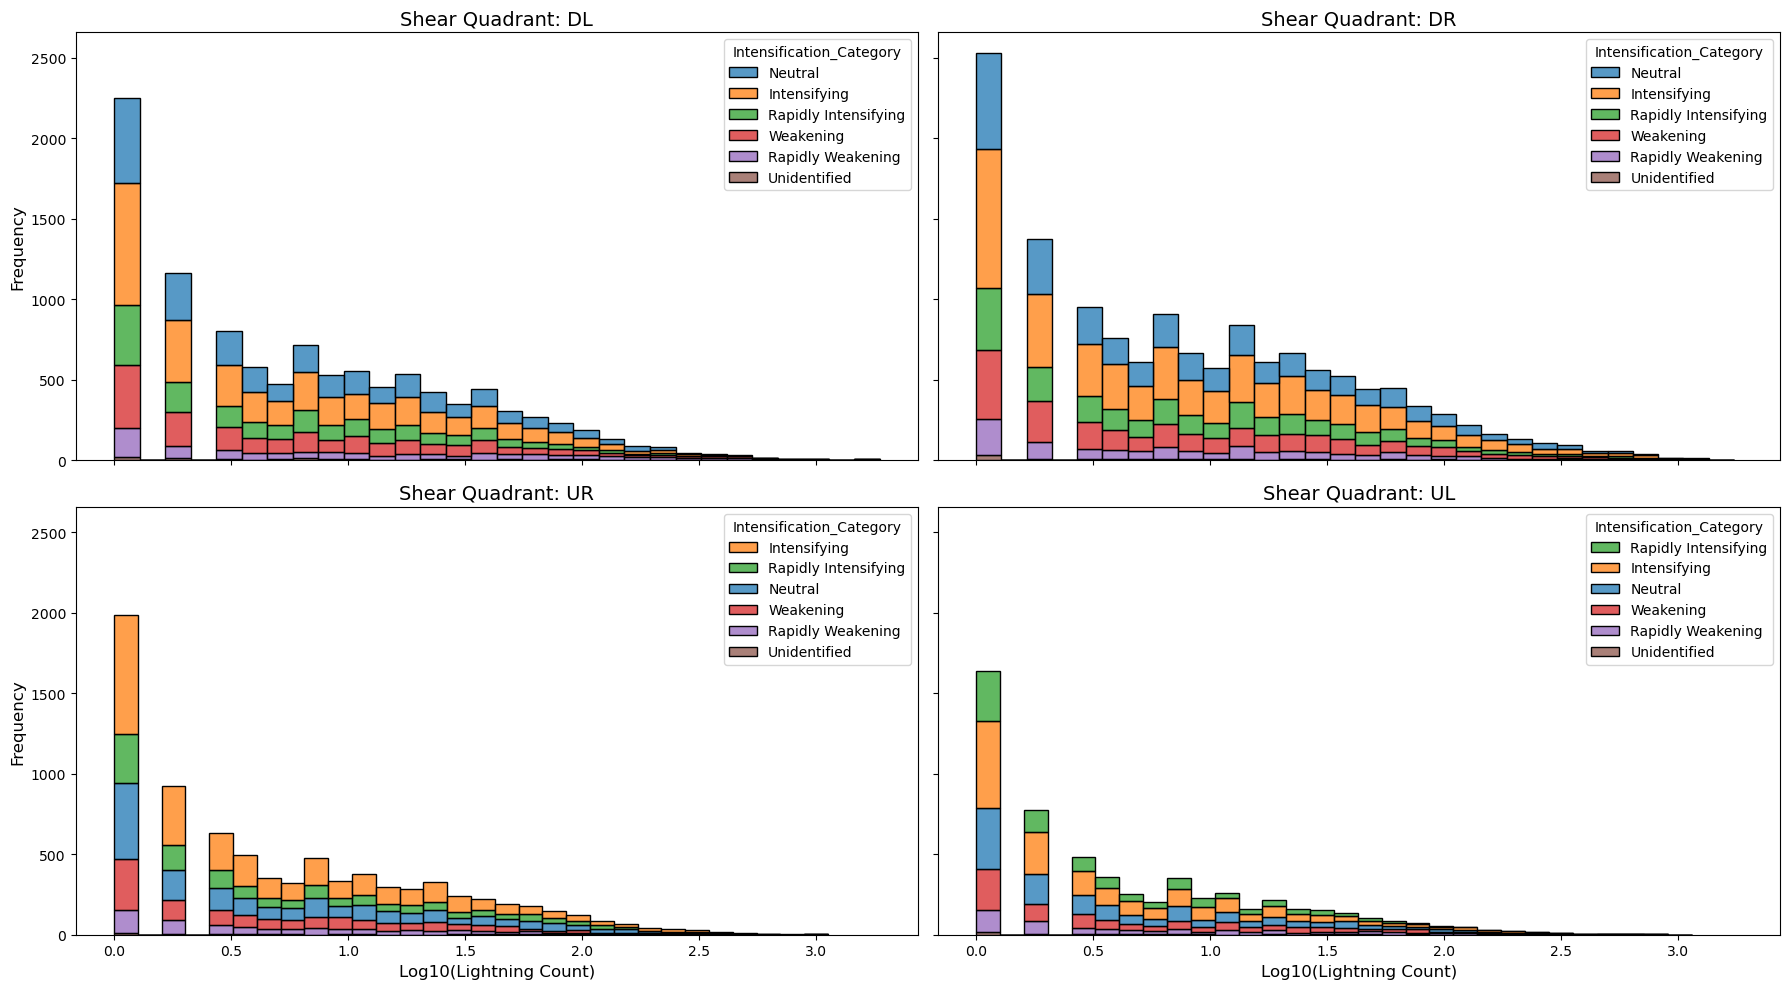

In [101]:
plot_log_dist_intensification(wpac_rainband)

Do the same for current category.

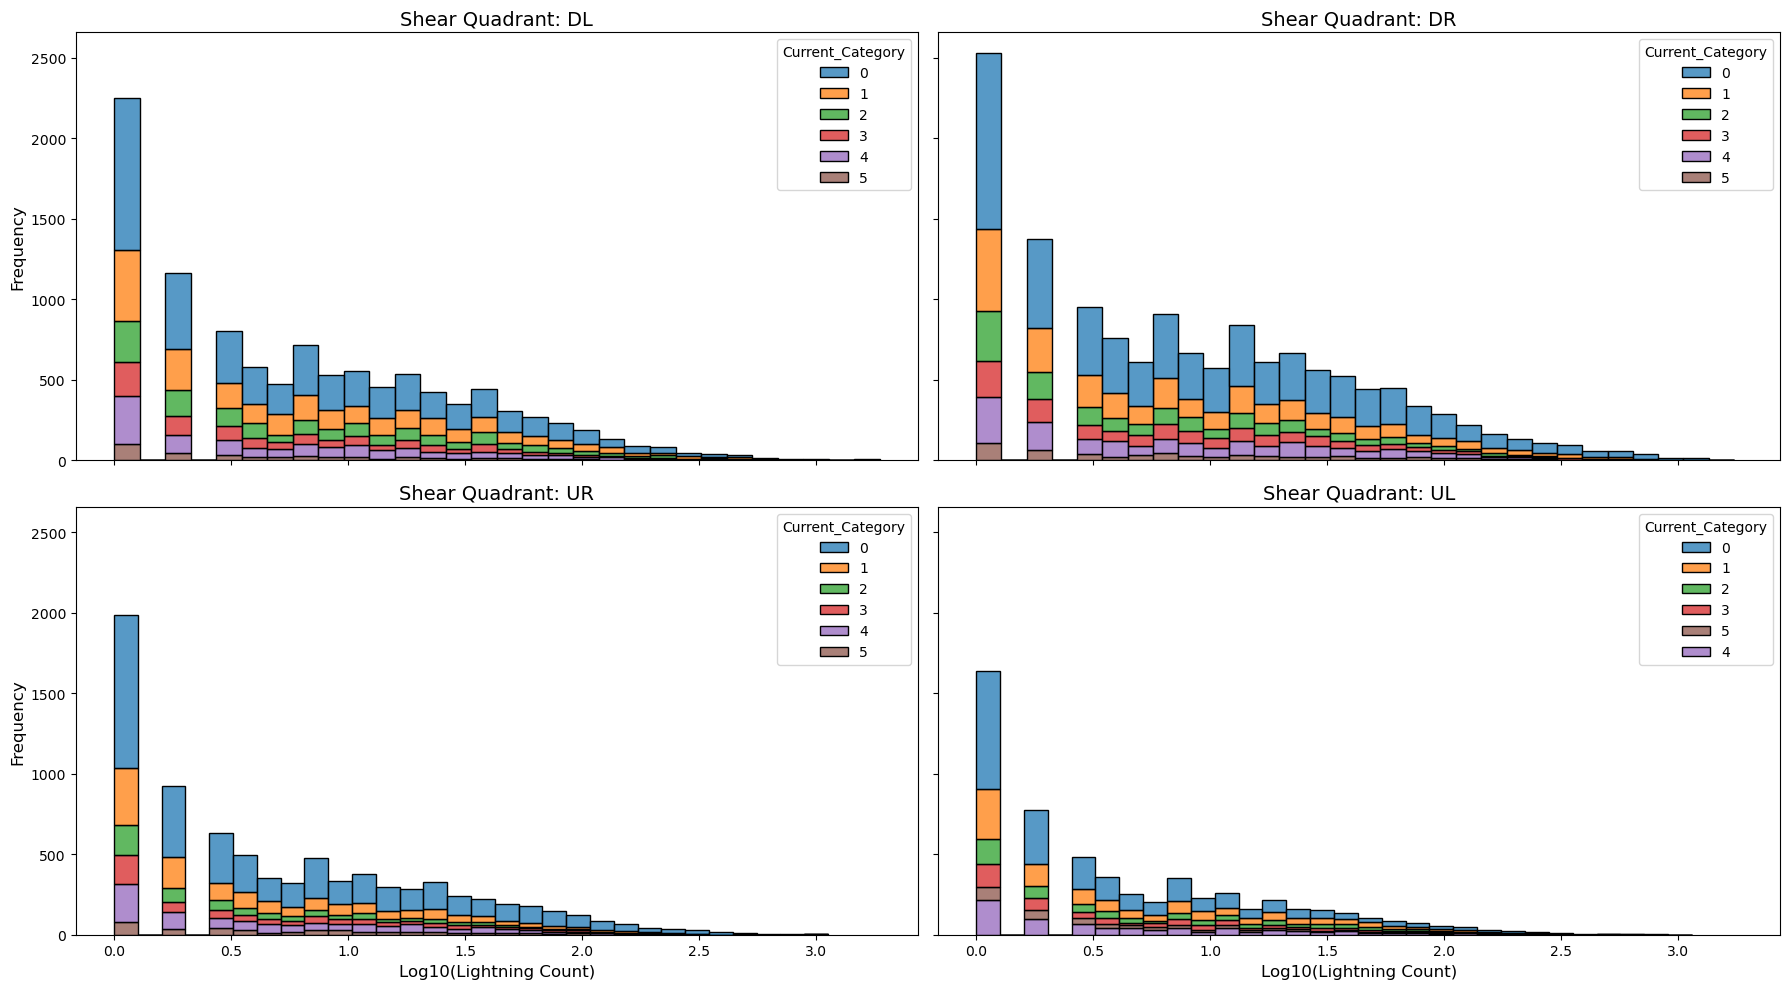

In [102]:
plot_log_dist_currentcategory(wpac_rainband)